In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.figure_factory as ff
import plotly.offline as py
import seaborn as sns

mpl.rcParams["figure.dpi"] = 300
plt.rcParams.update({'font.size': 22})
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['ytick.labelsize']=14
py.init_notebook_mode(connected=False)
mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# VISUAL NOTES FROM SINGAPORE'S FIRST 100 FULLY RECOVERED COVID-19 PATIENTS

Since Singapore's first confirmed Covid-19 case emerged on January 23, several excellent dashboards have been published online to track the progress of the outbreak. I highly recommend checking out the following dashboards by:

* [Upcode Academy](https://co.vid19.sg/)

* [The Health Ministry of Singapore](https://experience.arcgis.com/experience/7e30edc490a5441a874f9efe67bd8b89)

* [CNA](https://infographics.channelnewsasia.com/covid-19/coronavirus-singapore-clusters.html?cid=covid19_desktop-banner_19022020_cna)

* [The Straits Times](https://www.straitstimes.com/multimedia/graphics/2020/02/spore-virus-cases/index.html?shell)

There's little point in trying to repeat what these better resourced teams have done. What I'll try to do instead in this notebook is to focus on exploring two questions on everyone's mind:

* Q1: If infected, how long would a full recovery take? Does gender or age matter?
 - In the Singapore context, Covid-19 patients are deemed to have fully recovered only after they successfully  test negative for two swab tests at least 24 hours apart.
 - In other words, recovery from Covid-19 symptoms alone is not considered a full recovery and would not qualify you for discharge from hospitals in Singapore.
 - In this notebook, I'll use the term "confirmation-discharge window" as a shorthand for the **number of days between a patient's Covid-19 infection confirmation date, and his/her official discharge date**, as announced by the Singapore health ministry.

* Q2: If you have symptoms, how long do you have to wait to be certain that it is Covid-19?
 - This is tricky territory, given the global disparity in access to medical facilities and Covid-19 test kits. 
 - To avoid over-complicating matters, I'm defining this waiting period as the "symptoms-confirmation window", ie, the **number of days between the reported onset of symptoms and official confirmation of Covid-19 infection**.

Please refer to my [Medium post]() for more detailed background.

# DATA SOURCE AND CAVEATS

I assembled the dataset for Singapore's first 100 fully recovered patients manually from [daily press releases issued by Singapore's Health Ministry](https://www.moh.gov.sg/news-highlights/). You can download a copy of the [dataset here](https://www.dropbox.com/s/lszzgmcsfojczek/covid100_recovered.csv?dl=0).  

For the record, the 100 patients are: Cases 01-34, 36-40, 43-81, 83-89, 91-93, 95-96, 98, 102, 106-107, 110-112, 138, 148, and 151.

The first patient to have made a full recovery in Singapore was Case 07, a 35-year-old mainland Chinese national who was discharged on February 04, 8 days after he was confirmed to be Covid-19 positive on January 27 2020. 

The latest discharged patient added to this list of 100 is Case 102, a 41-year-old Filipino woman who was discharged on March 14 2020. 8 unrelated patients, including Case 102, were discharged on March 14, according to the [Singapore health ministry](https://www.moh.gov.sg/news-highlights/details/eight-more-cases-discharged-twelve-new-cases-of-covid-19-infection-confirmed). Recovered Patients 103, 135, 146, 150 and 160 were **not added to this dataset**.

Clearly, the overall number of Covid-19 cases in Singapore is still growing and this is merely an initial exploration. I decided to stick with the first 100 fully recovered patients for practical reasons.

I'm not an epidemiologist or medical researcher, but I have taken care to use labels/definitions that are clear, unambiguous and non-alarmist. Errors are all mine.

Minor note to non-Singapore readers/users: Raw dates were initially recorded in day/month/year format per the norm in Singapore. Take note if you are doing your own date data transformation in pandas (accounted for below, with "dayfirst").

# 1. DATA PRE-PROCESSING

In [2]:
raw = pd.read_csv('../data/covid100_recovered.csv')

In [3]:
raw.head()

Confirmed Case ID Date of Arrival in Singapore Date Announced by MOH  \
0           Case 01                    20/1/2020             23/1/2020   
1           Case 02                    21/1/2020             24/1/2020   
2           Case 03                    20/1/2020             24/1/2020   
3           Case 04                    22/1/2020             26/1/2020   
4           Case 05                    18/1/2020             27/1/2020   

  Date of Symptoms Date of Admission to Hospital Date Confirmed Positive  \
0        20/1/2020                     22/1/2020               23/1/2020   
1        21/1/2020                     22/1/2020               24/1/2020   
2        23/1/2020                     23/1/2020               24/1/2020   
3        23/1/2020                     24/1/2020               25/1/2020   
4        24/1/2020                     26/1/2020               27/1/2020   

  Date Discharged  Category Nationality   Age Gender  
0       19/2/2020  Imported       China  66.0      M  
1        7/2/2020  Imported       China  53.0      F  
2       21/2/2020  Imported       China  37.0      M  
3       12/2/2020  Imported       China  36.0      M  
4       18/2/2020  Imported       China  56.0      F

## 1.1 EXTRACT AND TRANSFORM DATE-RELATED DATA

The health ministry has released detailed information about when a patient first reported symptoms, went to the hospital, was confirmed to have been infected and when he/she was discharged. 

So the first step would be to extract these essential bits of information for our analysis, as well as the number of days between discharge and confirmation, and number of days between onset of symptoms and confirmation.

In [4]:
# Converting date cols to datetime

raw["Symptoms Date"] = pd.to_datetime(raw["Date of Symptoms"], dayfirst=True).dt.date

raw["Hospital Date"] = pd.to_datetime(
    raw["Date of Admission to Hospital"], dayfirst=True
).dt.date

raw["Confirmed Date"] = pd.to_datetime(raw["Date Confirmed Positive"], dayfirst=True).dt.date

raw["Discharged Date"] = pd.to_datetime(raw["Date Discharged"], dayfirst=True).dt.date

In [5]:
# Extracting days between onset of symptoms and confirmation of infection
raw["Days Between Symptoms And Covid-19 Confirmation"] = (
    raw["Confirmed Date"] - raw["Symptoms Date"]
).dt.days

# Extracting days taken for full recovery, ie,
# between confirmation of infection and discharge from hospital

raw["Days Between Hospital Discharge And Covid-19 Confirmation"] = (
    raw["Discharged Date"] - raw["Confirmed Date"]
).dt.days


## 1.2 EXTRACT AND TRANSFORM AGE-RELATED DATA

The ministry also releases the ages of all patients. For this analysis, I want to look at age-ranges over a 10-year interval.

In [6]:
# In this dataset, we don't have anyone above 80 years old
# The oldest known Covid-19 patient in S'pore thus far is Case 181
# Case 181 is an imported case involving a 83-year-old Indonesian national, and remains hospitalised

raw["0-9"] = np.where(raw["Age"] < 10, "Ages 0-9", "")

raw["10-19"] = np.where(
    ((raw["Age"] >= 10) & (raw["Age"] < 20)), "Ages 10-19", ""
)

raw["20-29"] = np.where(
    ((raw["Age"] >= 20) & (raw["Age"] < 30)), "Ages 20-29", ""
)

raw["30-39"] = np.where(
    ((raw["Age"] >= 30) & (raw["Age"] < 40)), "Ages 30-39", ""
)

raw["40-49"] = np.where(
    ((raw["Age"] >= 40) & (raw["Age"] < 50)), "Ages 40-49", ""
)

raw["50-59"] = np.where(
    ((raw["Age"] >= 50) & (raw["Age"] < 60)), "Ages 50-59", ""
)

raw["60-69"] = np.where(
    ((raw["Age"] >= 60) & (raw["Age"] < 70)), "Ages 60-69", ""
)

raw["70-79"] = np.where(
    ((raw["Age"] >= 70) & (raw["Age"] < 80)), "Ages 70-79", ""
)


raw["Age Range"] = raw[
    [
        "0-9",
        "10-19",
        "20-29",
        "30-39",
        "40-49",
        "50-59",
        "60-69",
        "70-79",
    ]
].apply("".join, axis=1)

raw = raw.drop(
    columns=[
        "0-9",
        "10-19",
        "20-29",
        "30-39",
        "40-49",
        "50-59",
        "60-69",
        "70-79",
    ]
).copy()


## 1.3 CREATING 2 NEW DFs FOR ANALYSIS/VISUALISATION

We won't need the full dataset for the subsequent charts, so let's create two smaller slices for the subsequent steps. 

In [7]:
# This DF for tracking full recovery 

recovery = raw[
    [
        "Confirmed Case ID",
        "Age",
        "Age Range",
        "Gender",
        "Category",
        "Nationality",
        "Confirmed Date",
        "Discharged Date",
        "Days Between Hospital Discharge And Covid-19 Confirmation",
    ]
]

In [8]:
recovery.head()

Confirmed Case ID   Age   Age Range Gender  Category Nationality  \
0           Case 01  66.0  Ages 60-69      M  Imported       China   
1           Case 02  53.0  Ages 50-59      F  Imported       China   
2           Case 03  37.0  Ages 30-39      M  Imported       China   
3           Case 04  36.0  Ages 30-39      M  Imported       China   
4           Case 05  56.0  Ages 50-59      F  Imported       China   

  Confirmed Date Discharged Date  \
0     2020-01-23      2020-02-19   
1     2020-01-24      2020-02-07   
2     2020-01-24      2020-02-21   
3     2020-01-25      2020-02-12   
4     2020-01-27      2020-02-18   

   Days Between Hospital Discharge And Covid-19 Confirmation  
0                                                 27          
1                                                 14          
2                                                 28          
3                                                 18          
4                                                 22

In [9]:
# This DF for tracking the waiting period between onset of symptoms and confirmation

symptoms = raw[
    [
        "Confirmed Case ID",
        "Age",
        "Age Range",
        "Gender",
        "Category",
        "Nationality",
        "Symptoms Date",
        "Confirmed Date",
        "Days Between Symptoms And Covid-19 Confirmation",
    ]
]

In [10]:
symptoms.head()

Confirmed Case ID   Age   Age Range Gender  Category Nationality  \
0           Case 01  66.0  Ages 60-69      M  Imported       China   
1           Case 02  53.0  Ages 50-59      F  Imported       China   
2           Case 03  37.0  Ages 30-39      M  Imported       China   
3           Case 04  36.0  Ages 30-39      M  Imported       China   
4           Case 05  56.0  Ages 50-59      F  Imported       China   

  Symptoms Date Confirmed Date  \
0    2020-01-20     2020-01-23   
1    2020-01-21     2020-01-24   
2    2020-01-23     2020-01-24   
3    2020-01-23     2020-01-25   
4    2020-01-24     2020-01-27   

   Days Between Symptoms And Covid-19 Confirmation  
0                                              3.0  
1                                              3.0  
2                                              1.0  
3                                              2.0  
4                                              3.0

# 2. DEMOGRAPHIC BREAKDOWN OF FIRST 100 FULLY RECOVERED PATIENTS

* I don't intend on duplicating the excellent Covid-19 dashboards already out there. But some charts broken down along demographic lines would still be useful for the analysis in this post.

* For this, I created an interactive chart on Flourish that can get the job done quickly. You can access it [here](https://public.flourish.studio/visualisation/1506209/).

## 2.1 FIRST 100 FULLY RECOVERED PATIENTS, BY GENDER

* 40 women, 60 men in our sample.

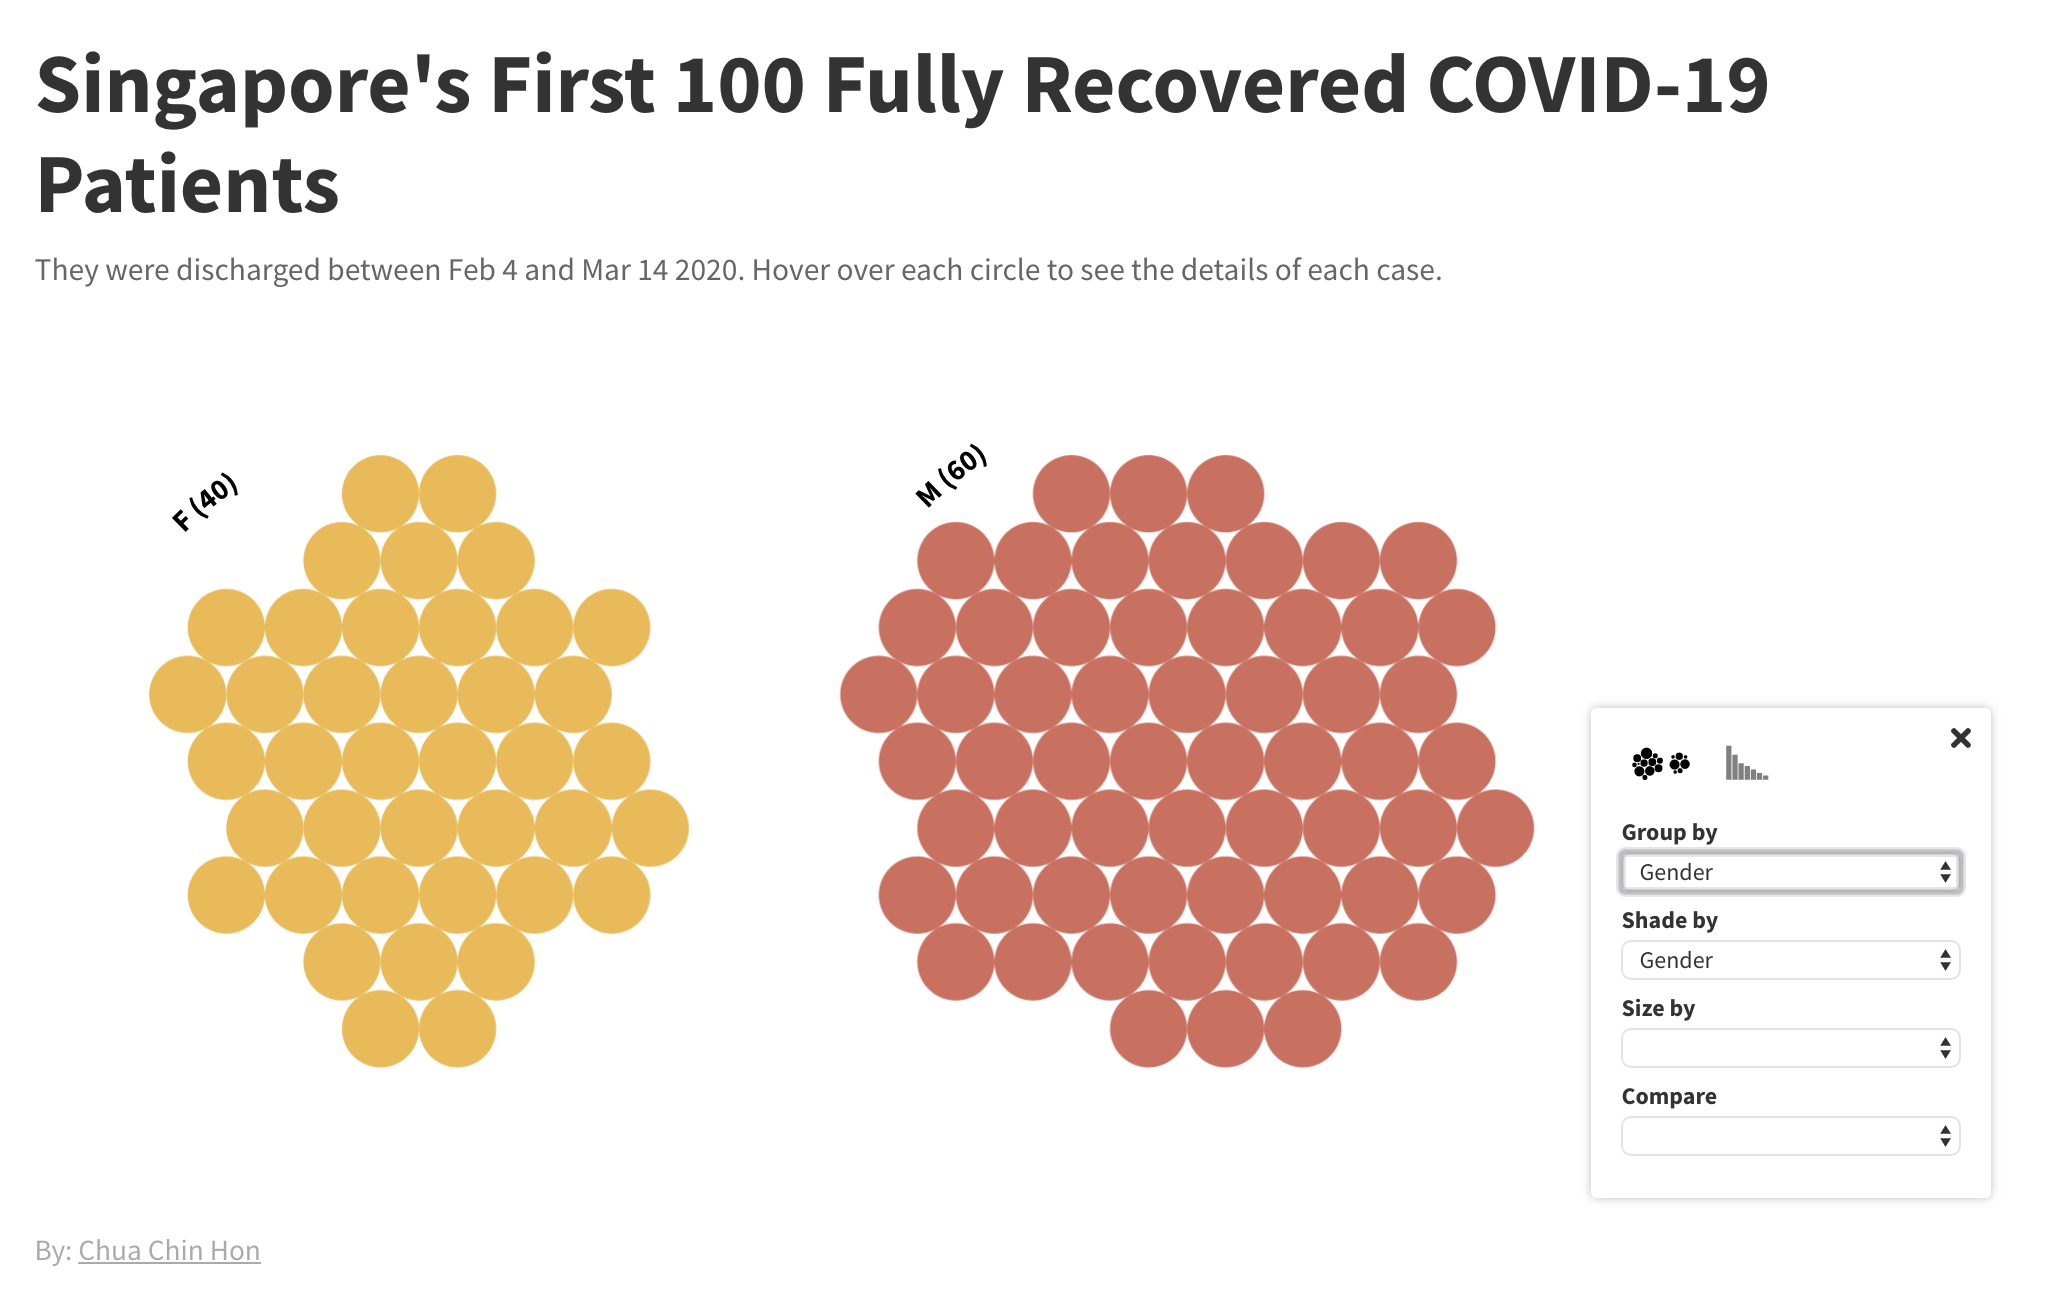

## 2.2 FIRST 100 FULLY RECOVERED PATIENTS, BY NATIONALITY

* 8 groups here, if we consider Singapore permanent residents separately:
 - 67 Singaporeans
 - 19 mainland Chinese nationals
 - 6 Singapore PRs
 - 4 Bangladeshis
 - 1 each of nationals from Indonesia, Japan, Malaysia and the Philippines


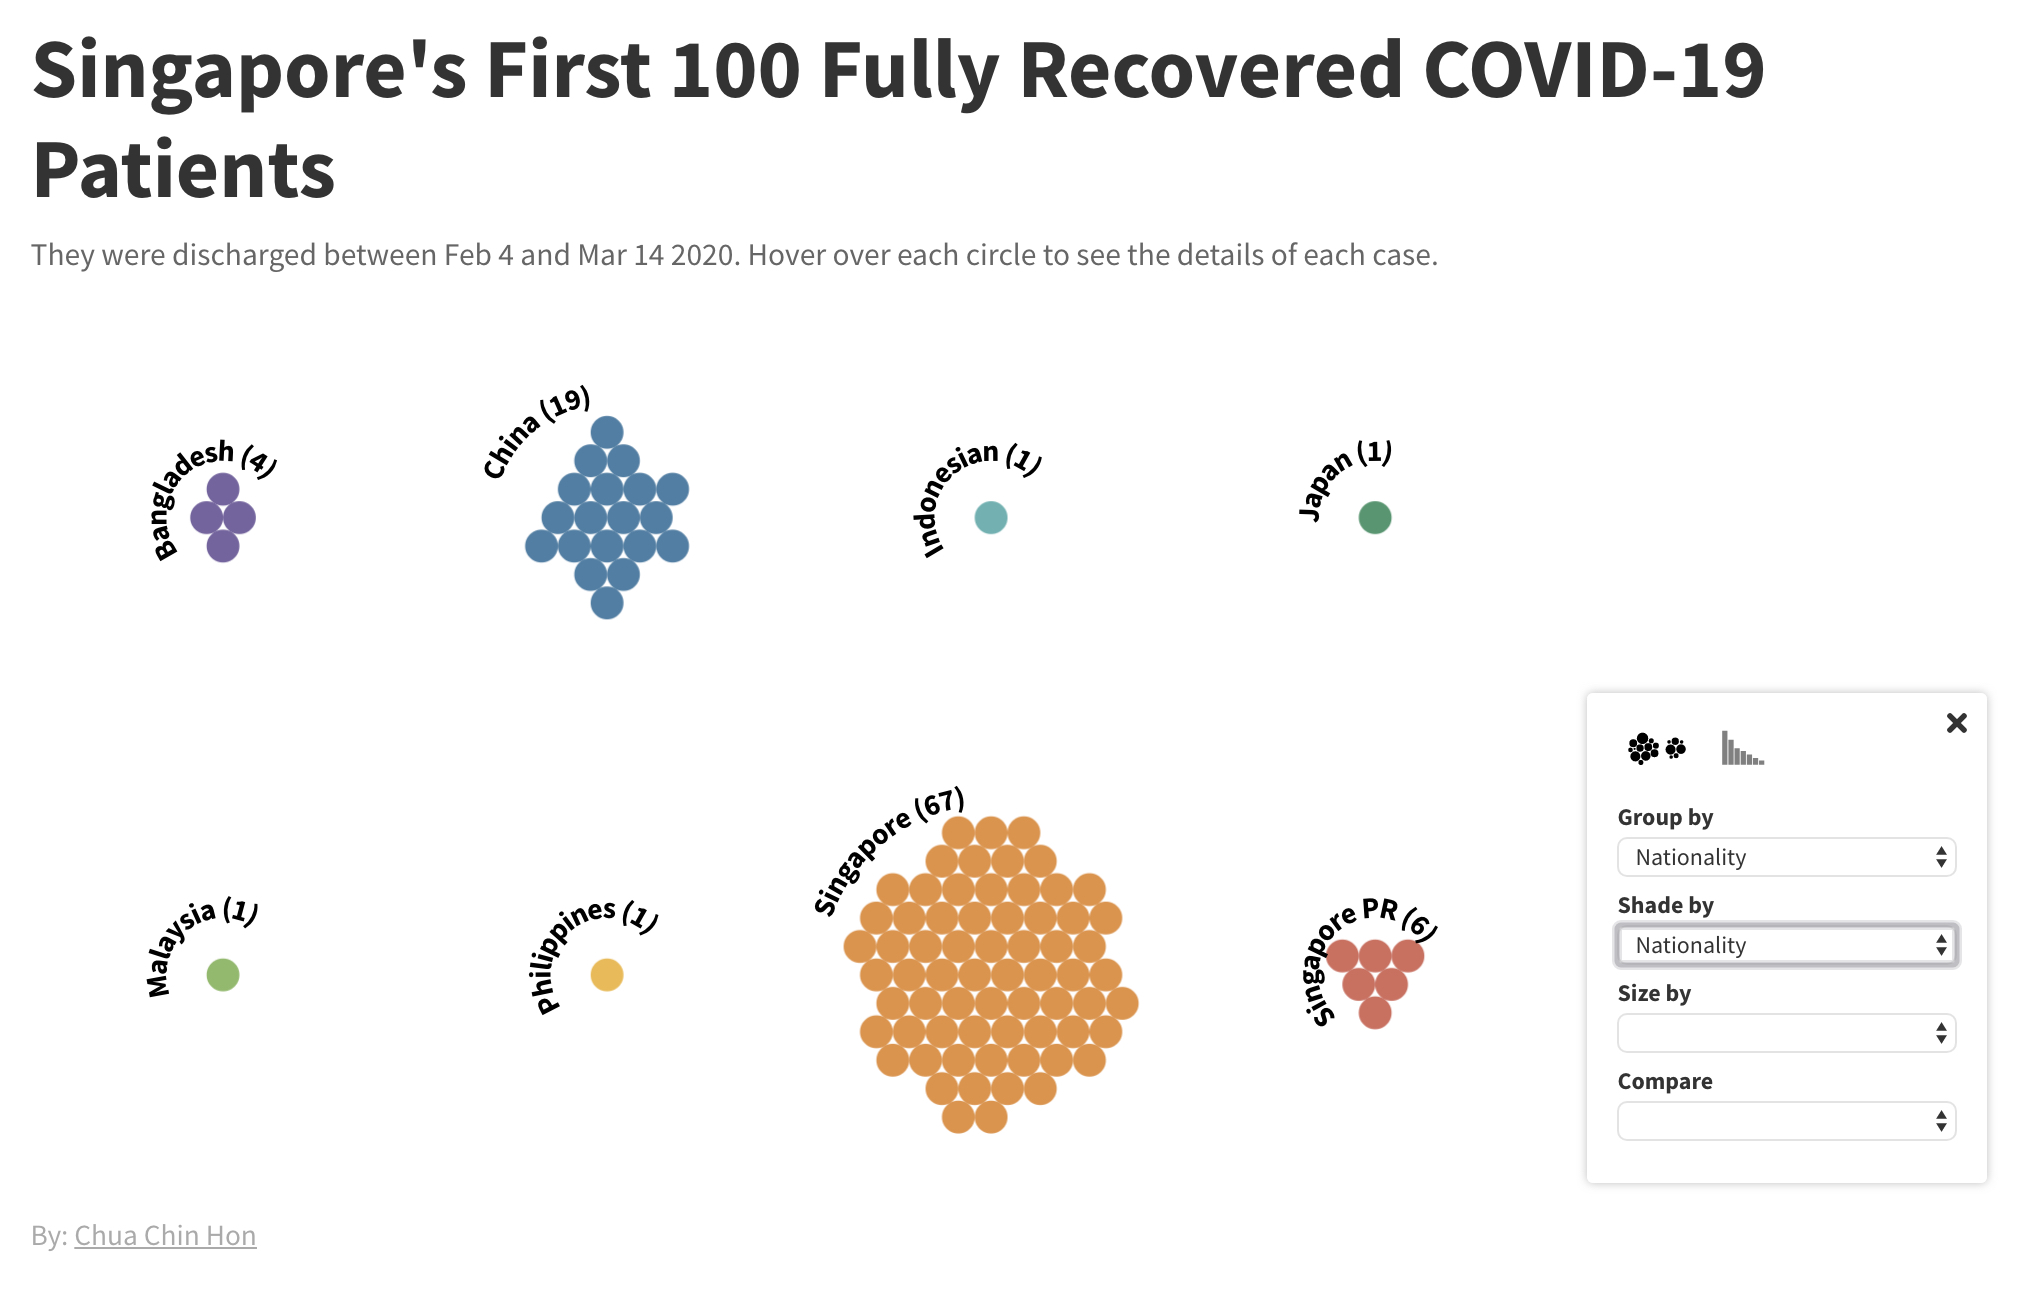

## 2.3 FIRST 100 FULLY RECOVERED PATIENTS, BY CATEGORY (IMPORT VS LOCAL TRANSMISSION)

* 23 imported cases, and 77 cases of local transmission.

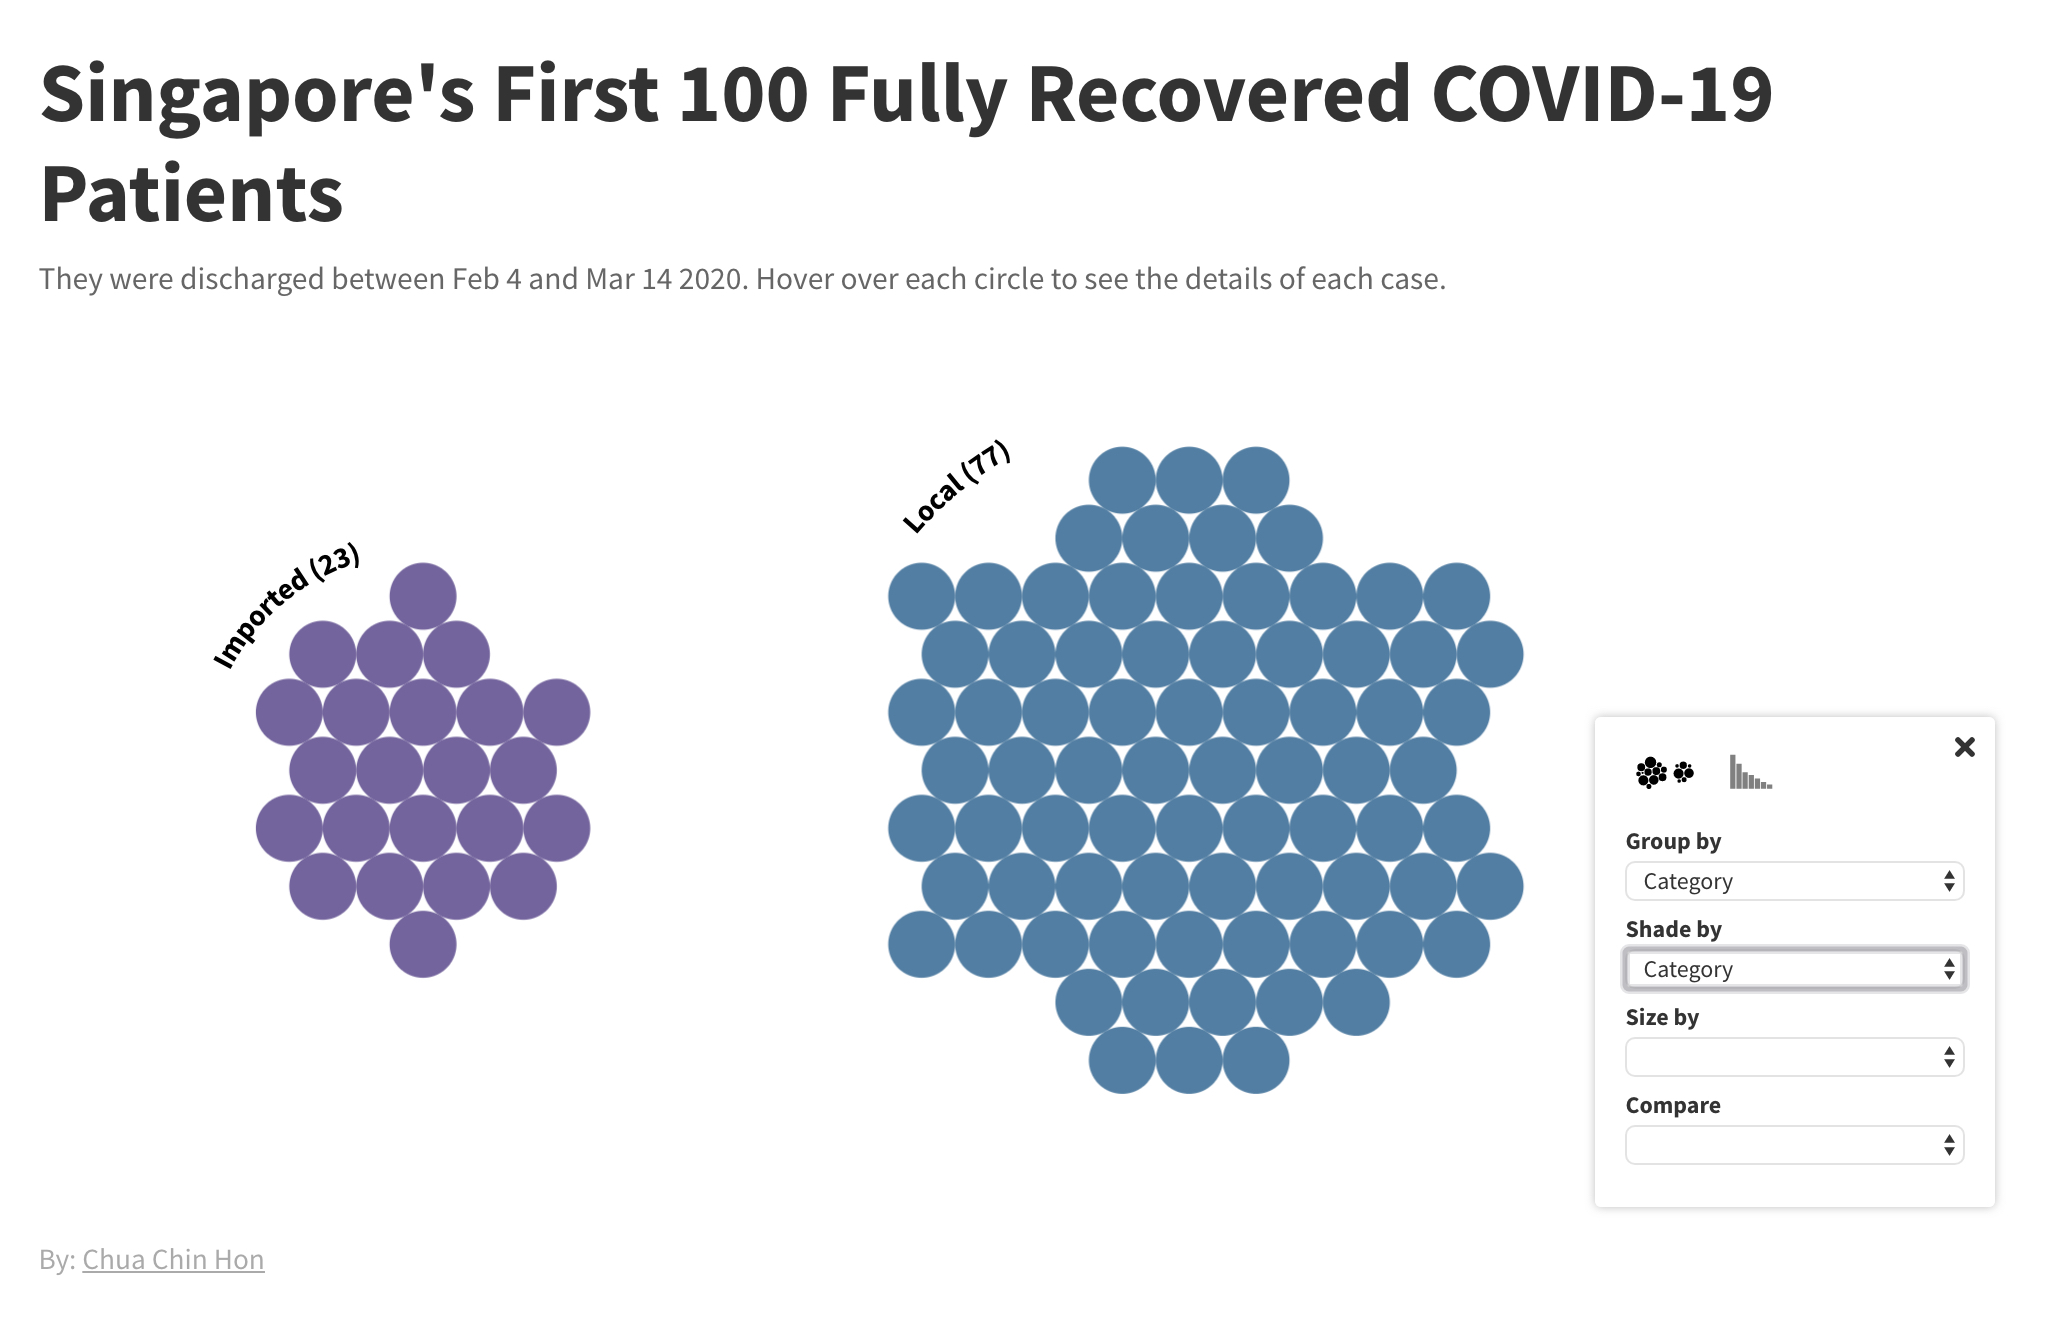

## 2.4 FIRST 100 FULLY RECOVERED PATIENTS, BY AGE

The bulk of the first 100 fully recovered patients - 75 - are aged between 30 to 59 years old.

* The single age range that has the most confirmed Covid-19 patients is the 30-39 segment, with 28 people (18 men and 10 women). 

In [11]:
age = recovery.sort_values(by="Age Range", ascending=False)

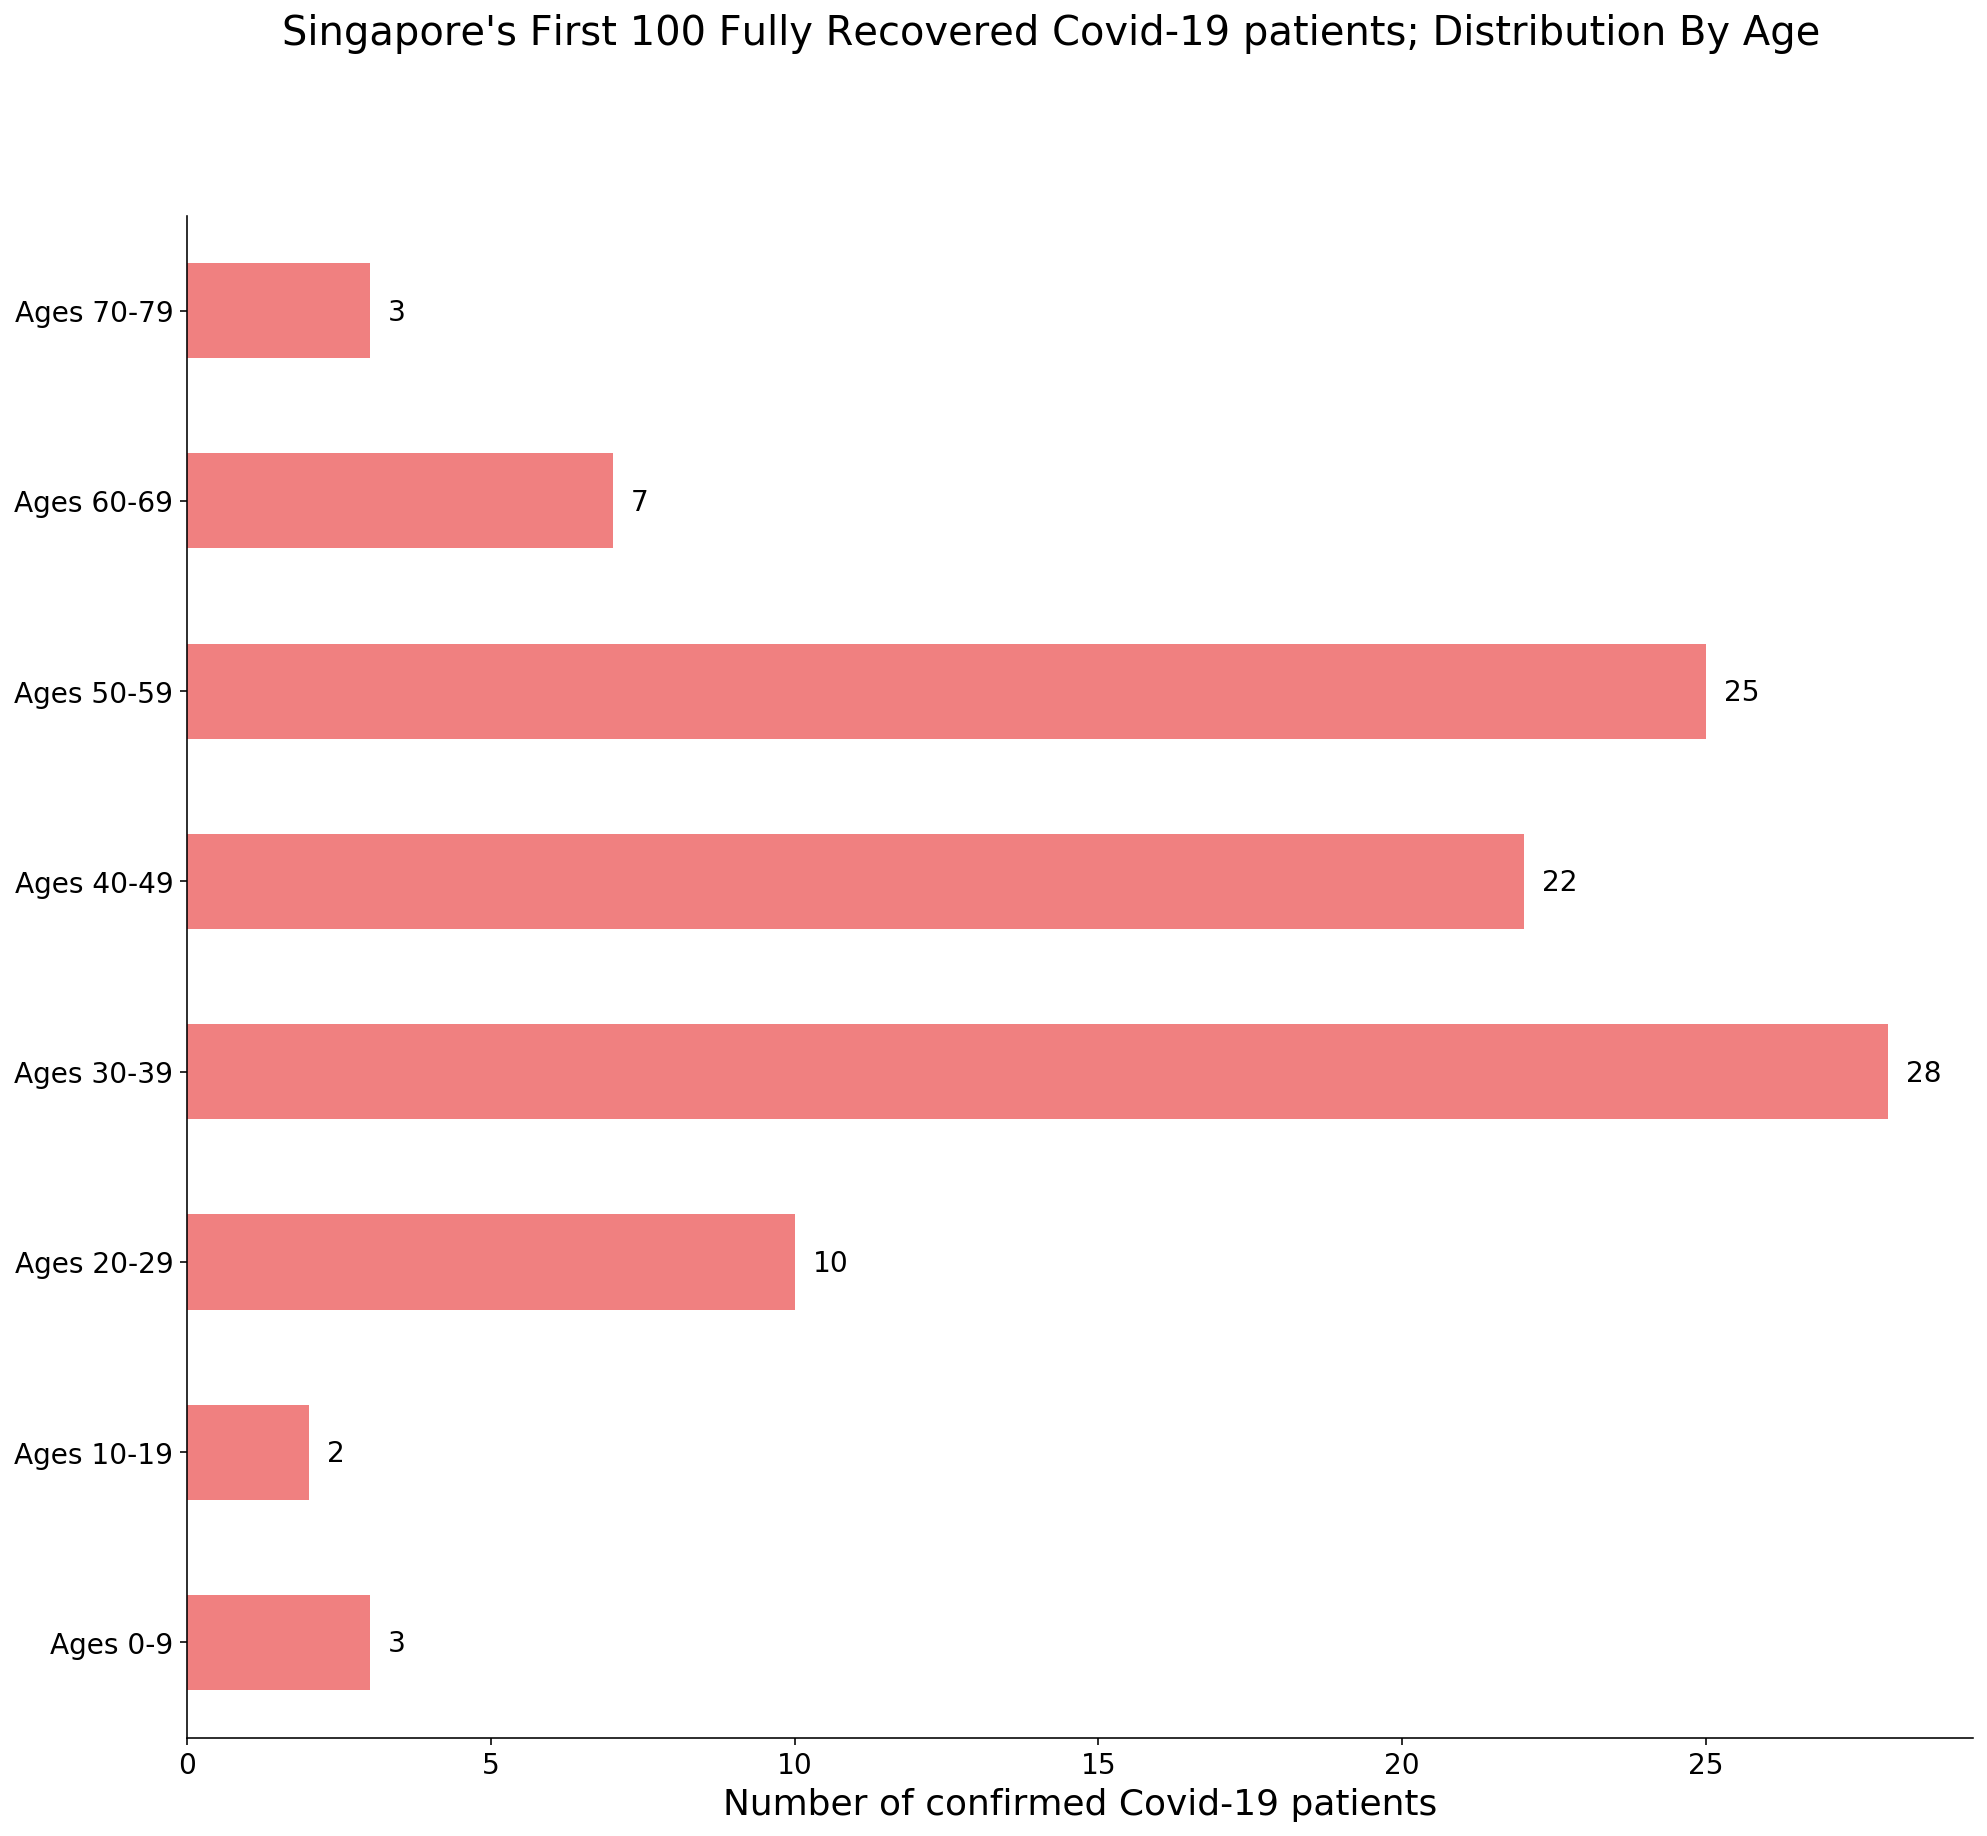

In [12]:
fig, ax = plt.subplots(figsize=(16, 14))

age["Age Range"].value_counts().sort_index(ascending=True).plot(
    kind="barh", color="lightcoral"
)

totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(
        i.get_width() + 0.3,
        i.get_y() + 0.2,
        str(round((i.get_width()))),
        fontsize=14,
        color="black",
    )

fig.suptitle(
    "Singapore's First 100 Fully Recovered Covid-19 patients; Distribution By Age", fontsize=20
)

plt.ylabel("", fontsize=18)
plt.xlabel("Number of confirmed Covid-19 patients", fontsize=18)

ax.grid(False)
sns.despine()
plt.show()

# 3. IF YOU'VE TESTED POSITIVE FOR COVID-19, HOW LONG WOULD A FULL RECOVERY TAKE? DOES YOUR AGE OR GENDER MATTER?

This is a complex question that depends a lot on other factors, such as a person's health and underlying medical condition. 

The most important thing to note on this issue is that **recovery from the symptoms of Covid-19 alone is NOT considered a full recovery**. A Covid-19 patient is considered to have fully recovered only after additional tests prove that he or she has stopped transmitting the virus. There is currently [no global standard on how many tests are needed](https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-Discharge-criteria.pdf) to be certain of this.

In the Singapore context, Covid-19 patients are deemed to have fully recovered only after they successfully [test negative for two swab tests at least 24 hours apart](https://www.moh.gov.sg/covid-19/faqs).

Another key point to note: The Singapore authorities do not disclose how long a patient took to recover from symptoms at the hospital, versus the time he or she spent waiting for results of the swab tests. For this reason, I'm avoiding usage of labels like "recovery period", which can easily lead to confusion and hasty conclusions.

In this post, I'll use the term "confirmation-discharge window" as a shorthand for the number of days between a patient's Covid-19 infection confirmation date, and his/her official discharge date, as announced by the Singapore health ministry. These dates are matters of public record and are not in dispute.

The definition is clunky but it is important that we are focused on what the limited public data actually says, instead of going down the slippery road of over-interpreting what **we think** the data says.

# 3.1 OVERVIEW

Overall, the first 100 Covid-19 patients to be discharged in Singapore took between one and 31 days for a full recovery (that is, they passed two consecutive swab tests).

The median number of days between confirmation of infection and discharge is 11 days. I'll be using the median number of days going ahead, given the considerable gap between the minimum and maximum values here. 

Boxplots will be a good option for analysing subsequent breakdowns by gender and age-range.

In [13]:
print(
    "Average number of days between hospital discharge and Covid-19 confirmation: ",
    recovery["Days Between Hospital Discharge And Covid-19 Confirmation"].mean(),
)

print(
    "Median number of days between hospital discharge and Covid-19 confirmation: ",
    recovery["Days Between Hospital Discharge And Covid-19 Confirmation"].median(),
)

print(
    "Minimum number of days between hospital discharge and Covid-19 confirmation: ",
    recovery["Days Between Hospital Discharge And Covid-19 Confirmation"].min(),
)

print(
    "Maximum number of days between hospital discharge and Covid-19 confirmation: ",
    recovery["Days Between Hospital Discharge And Covid-19 Confirmation"].max(),
)


Average number of days between hospital discharge and Covid-19 confirmation:  12.29
Median number of days between hospital discharge and Covid-19 confirmation:  11.0
Minimum number of days between hospital discharge and Covid-19 confirmation:  1
Maximum number of days between hospital discharge and Covid-19 confirmation:  31


## 3.1.1 FREQUENCY DISTRIBUTION OF FULL RECOVERY PERIOD

* From the chart below, a third (33) of the patients took 15 days or more to be discharged, from the time of the confirmation of infection. Only 8 patients were discharged within 3 days or less of confirmation of infection.

* This illustrates the considerable amount of time and resources hospitals need to help the majority of Covid-19 patients recover from the symptoms **and** to stop the transmission of the virus. 

* If there's a massive spike in new Covid-19 infections, the existing healthcare system would come under tremendous strain from having to take in a high number of infectious patients.

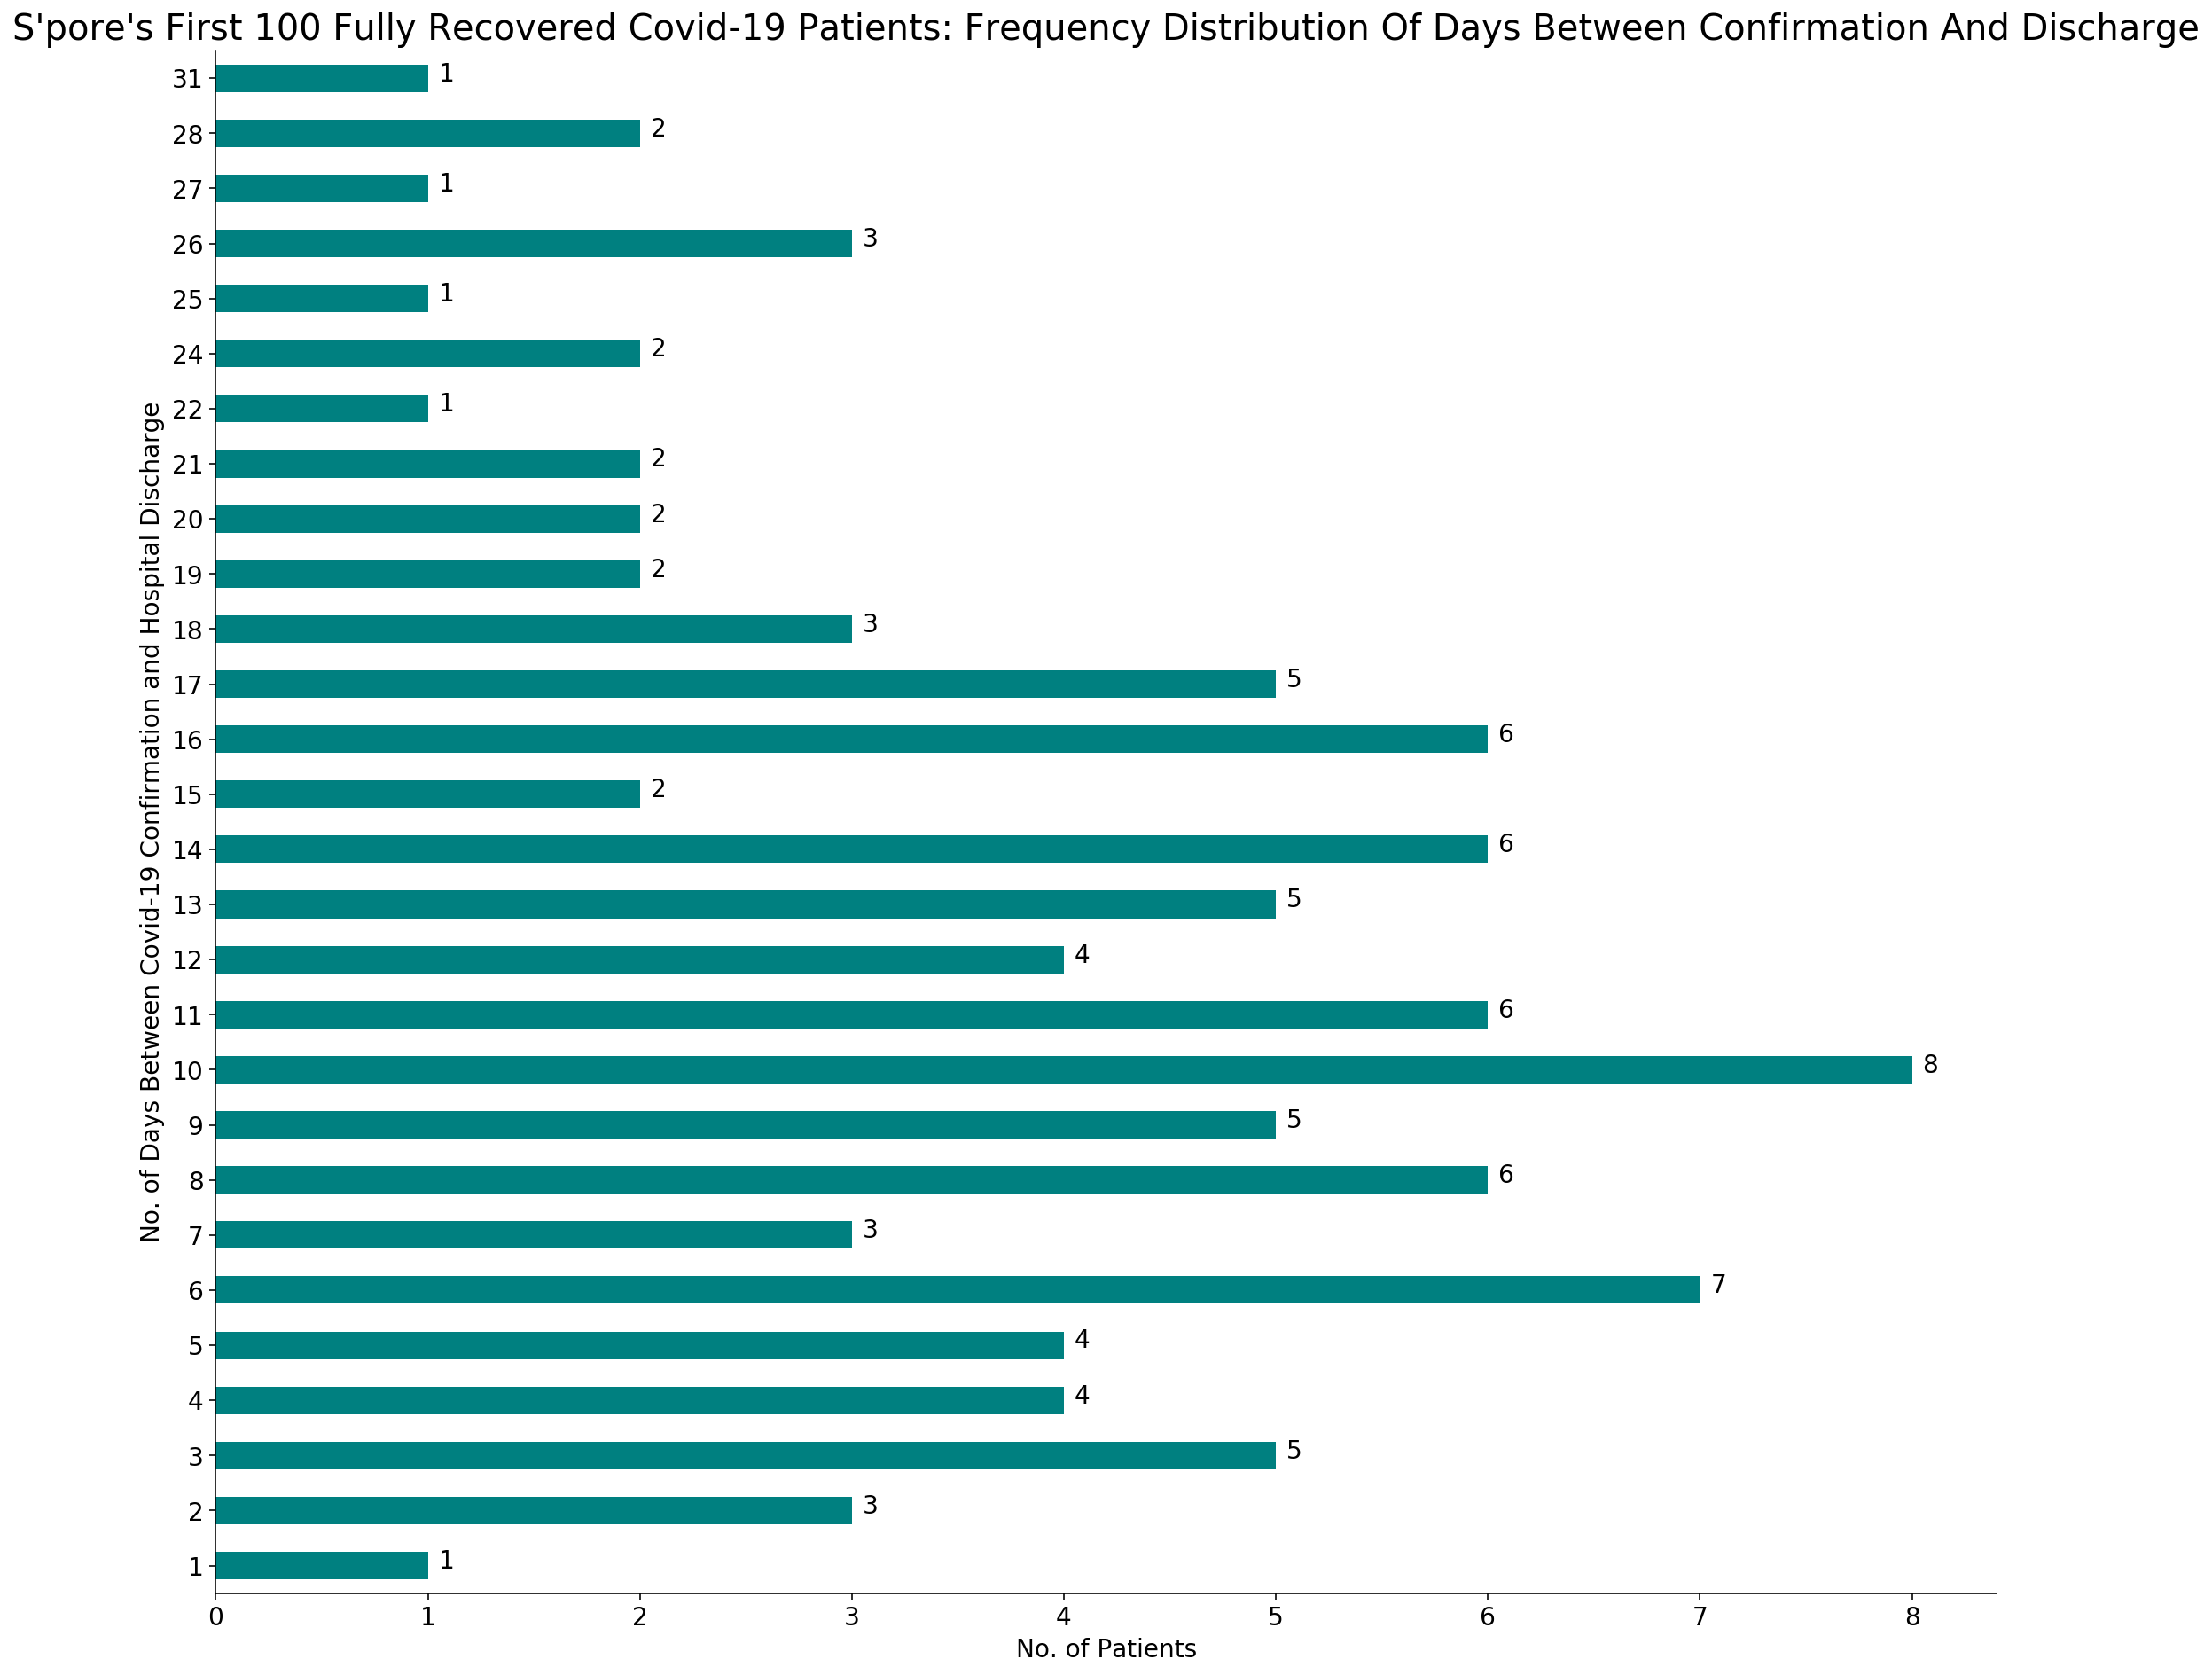

In [14]:
ax = (
    recovery["Days Between Hospital Discharge And Covid-19 Confirmation"]
    .value_counts()
    .sort_index(ascending=True)
    .plot(kind="barh", color="teal", figsize=(18, 16))
)

totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(
        i.get_width() + 0.05,
        i.get_y() + 0.2,
        str(round((i.get_width()))),
        fontsize=14,
        color="black",
    )

plt.title(
    "S'pore's First 100 Fully Recovered Covid-19 Patients: Frequency Distribution Of Days Between Confirmation And Discharge",
    fontsize=20,
)
plt.xlabel("No. of Patients", fontsize=14)
plt.ylabel(
    "No. of Days Between Covid-19 Confirmation and Hospital Discharge", fontsize=14
)

plt.grid(False)
sns.despine()
plt.show()


## 3.1.2 GANTT CHART VISUALISATION OF OVERALL RECOVERY PATTERN

Gantt charts are typically used to illustrate a project's schedule. But in this case, it works pretty well in showing how long each patient took to recover. 

You can download a copy of the interactive Plotly chart [here as well](https://www.dropbox.com/s/s5hx02zgfqdj8bc/discharge_overview.html?dl=0). Hover over the bars in the html file to see the meta-data related to each patient.

I'll leave an in-depth interpretation of the Gannt chart to the epidemiologists. To my untrained eye, the chart is a striking illustration of how challenging it is to contain the Covid-19 outbreak, given how unpredictable the full recovery period is.

In [15]:
# Creating and renaming a new DF for the Gantt template on Plotly

recovery_plotly = recovery.rename(
    columns={
        "Confirmed Case ID": "Task",
        "Confirmed Date": "Start",
        "Discharged Date": "Finish",
        "Days Between Hospital Discharge And Covid-19 Confirmation": "Complete",
    }
)

In [16]:
fig = ff.create_gantt(
    recovery_plotly.dropna(),
    colors=["#009a9a", "#00b3b3"],
    index_col="Complete",
    data="Complete",
    bar_width=0.4,
    height=1200,
    width=1000,
    title="S'pore's First 100 Covid-19 Cases: Days Between Confirmation of Infection And Hospital Discharge",
)

fig.show()

## 3.2 UNUSUAL CASES 

Let's take a closer look at the cases that either took a very long for a full recovery, or were discharged unusually quickly.

### 3.2.1 WHICH CASES RECOVERED THE FASTEST?

* Case 151 is perhaps the most unusual of the lot. The Singapore health ministry's [official press release](https://www.moh.gov.sg/news-highlights/details/three-more-cases-discharged-ten-new-cases-of-covid-19-infection-confirmed) seems to suggest that the 51-year-old Singaporean man recovered from Covid-19 on his own, after first reporting onset of symptoms on February 4. It took the results of a [serological test](https://www.sciencemag.org/news/2020/02/singapore-claims-first-use-antibody-test-track-coronavirus-infections) on March 8 to confirm that he had an "earlier Covid-19 infection". He was discharged a day later on March 9.

* Cases 76, 83 and 84 took just 2 days to be discharged after they were officially confirmed to be infected. Cases 83 and 84 are part of the Mei Hwan Drive cluster that is in turn linked to two other church clusters.

* Patient 76 was among the Singaporeans evacuated from Wuhan, the epicenter of the outbreak, on February 9. He had shown no symptoms prior to boarding the flight, and was quarantined upon arrival in Singapore as part of the city-state’s containment measures. He tested positive for Covid-19 only on February 16.

* It remains unclear why these cases took such a short time to stage a full recovery.  

In [17]:
recovery[recovery['Days Between Hospital Discharge And Covid-19 Confirmation'] < 3]

Confirmed Case ID   Age   Age Range Gender  Category Nationality  \
72           Case 76   1.0    Ages 0-9      M  Imported   Singapore   
78           Case 83  54.0  Ages 50-59      M     Local   Singapore   
79           Case 84  35.0  Ages 30-39      F     Local   Singapore   
99          Case 151  51.0  Ages 50-59      M     Local   Singapore   

   Confirmed Date Discharged Date  \
72     2020-02-16      2020-02-18   
78     2020-02-19      2020-02-21   
79     2020-02-19      2020-02-21   
99     2020-03-08      2020-03-09   

    Days Between Hospital Discharge And Covid-19 Confirmation  
72                                                  2          
78                                                  2          
79                                                  2          
99                                                  1

### 3.2.2 WHICH CASE RECOVERED THE SLOWEST?

* [Cases 53](https://www.moh.gov.sg/news-highlights/details/eight-more-confirmed-cases-of-covid-19-infection) holds the record so far, taking 31 days from the time of confirmation of infection to his eventual discharge from hospital. The 54-year-old Singaporean man was part of a Covid-19 cluster linked to a local church, the Grace Assembly of God. He first reported onset of symptoms on February 10, and was tested positive for Covid-19 two days later.

* It is unclear how many days he spent recovering from symptoms related to his infection, versus the time needed for him to pass the swab tests.

In [18]:
recovery[recovery['Days Between Hospital Discharge And Covid-19 Confirmation'] == 31]

Confirmed Case ID   Age   Age Range Gender Category Nationality  \
49           Case 53  54.0  Ages 50-59      M    Local   Singapore   

   Confirmed Date Discharged Date  \
49     2020-02-12      2020-03-14   

    Days Between Hospital Discharge And Covid-19 Confirmation  
49                                                 31

## 3.3 DO MEN AND WOMEN FULLY RECOVER FROM COVID-19 AT A DIFFERENT PACE?

* There are 60 men and 40 women among Singapore's first 100 fully recovered Covid-19 patients. But the boxplot shows that both genders took the same median number of days for a full recovery - 11 days.

* The small sample size could be a factor, and it will be interesting to see how things change when more fully recovered patients are added to the mix. A [larger study](https://www.scmp.com/news/china/society/article/3074168/women-more-likely-survive-coronavirus-china-studies-find?utm_term=Autofeed&utm_medium=Social&utm_content=article&utm_source=Twitter#Echobox=1583702220) of 1,000 patients across China found that women were more likely to survive.

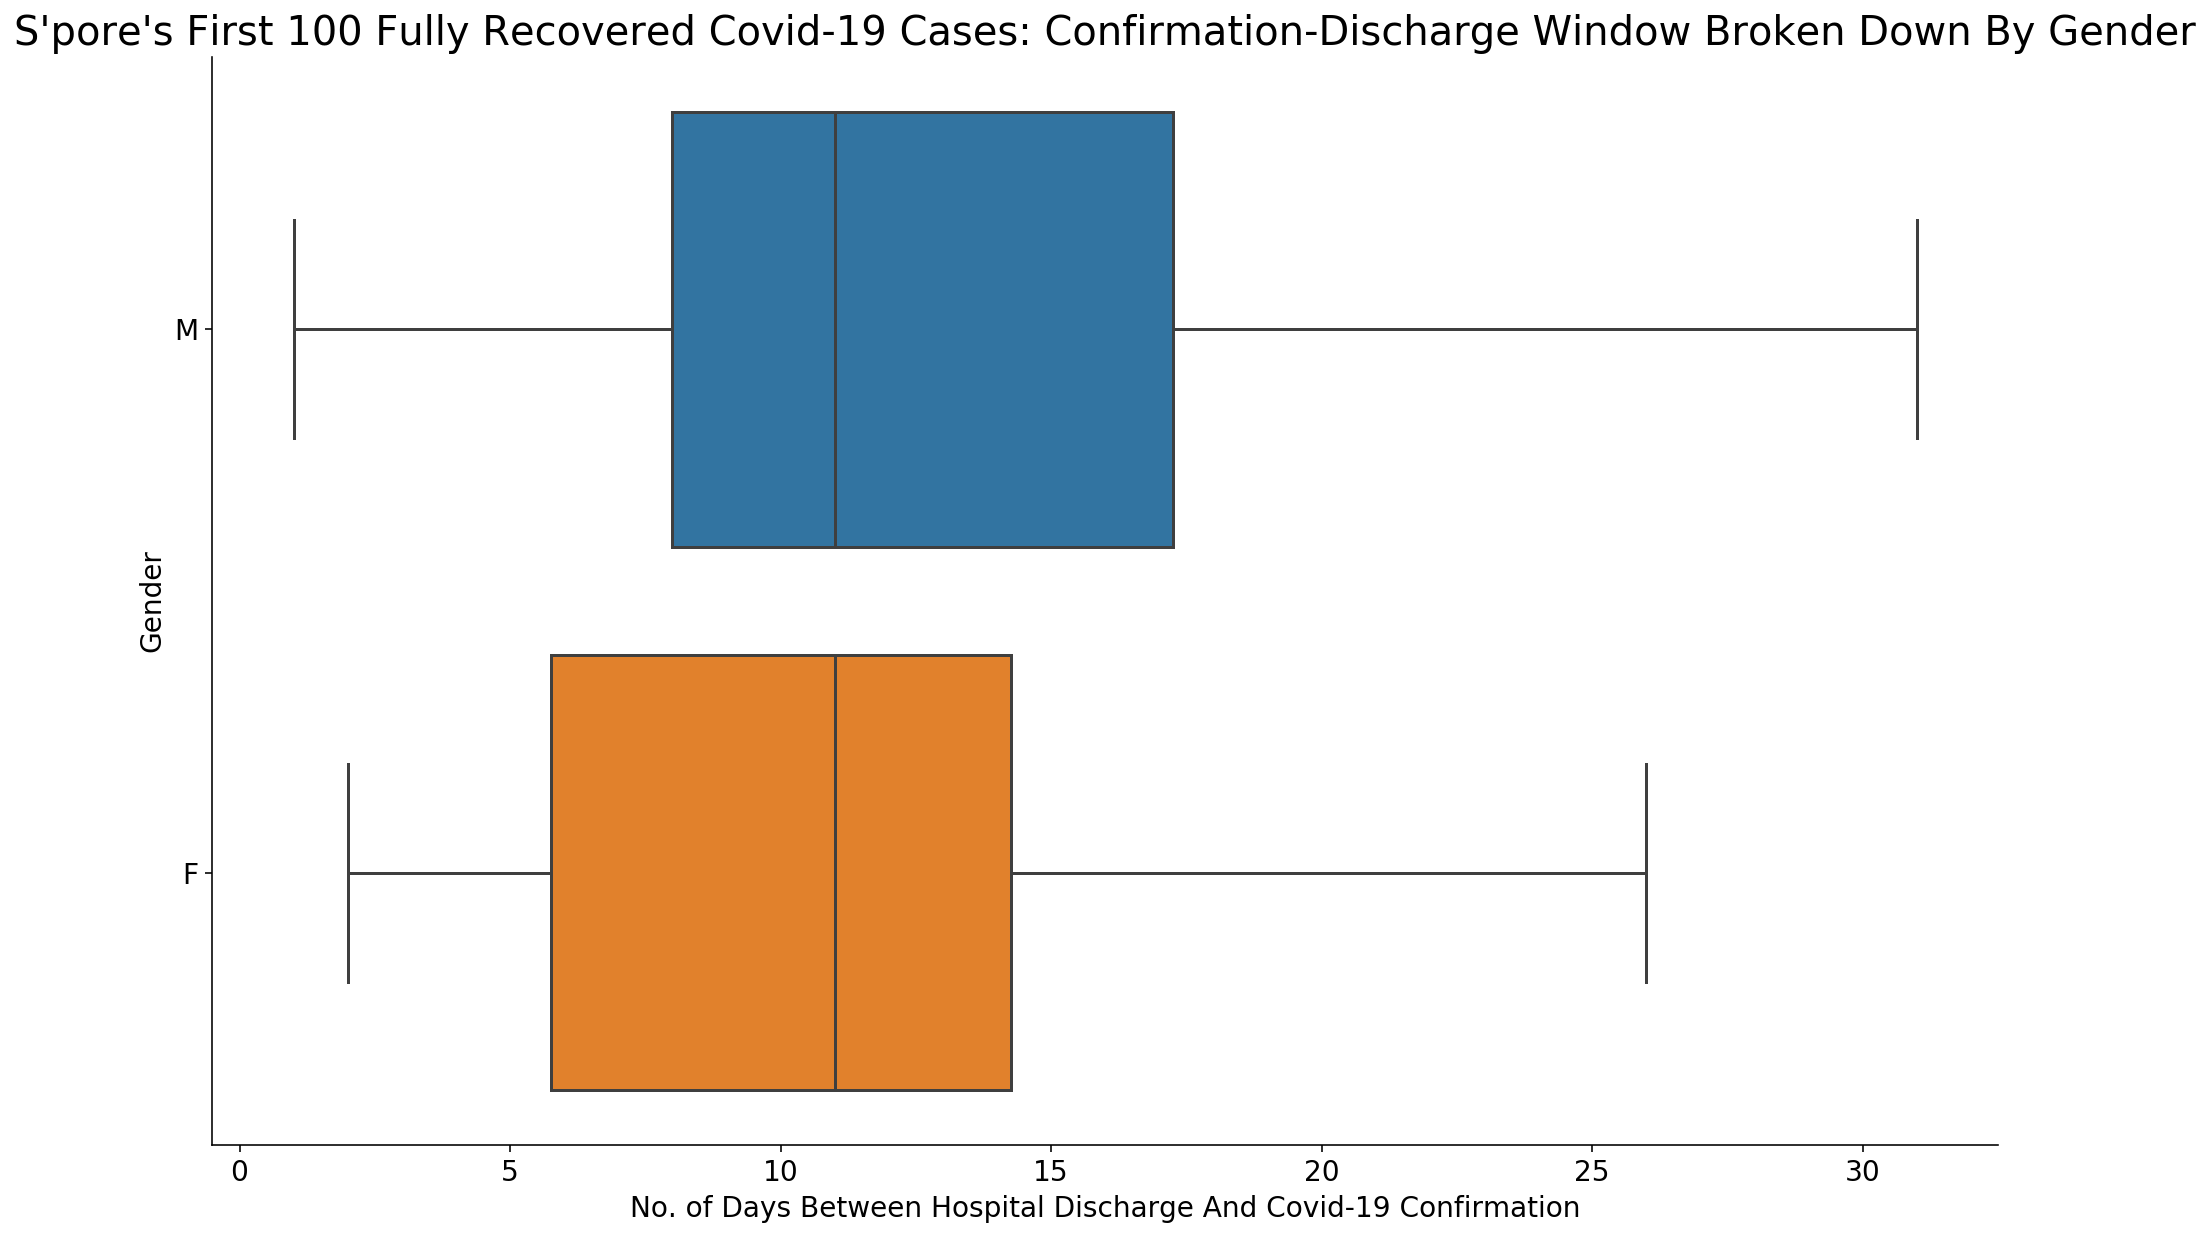

In [19]:
plt.figure(figsize=(16, 10))
sns.boxplot(
    x="Days Between Hospital Discharge And Covid-19 Confirmation",
    y="Gender",
    data=recovery,
)
plt.title(
    "S'pore's First 100 Fully Recovered Covid-19 Cases: Confirmation-Discharge Window Broken Down By Gender",
    fontsize=20,
)
plt.xlabel("No. of Days Between Hospital Discharge And Covid-19 Confirmation", fontsize=14)
plt.ylabel("Gender", fontsize=14)
plt.grid(False)
sns.despine()
plt.show()


## 3.4 DO THE YOUNG, THE MIDDLE-AGED, AND THE ELDERLY FULLY RECOVER FROM COVID-19 AT A DIFFERENT PACE?

* One will naturally assume that age has a bearing on recovery time, especially given the multiple reports out there about how the elderly are far more vulnerable to Covid-19. But the boxplot for Age Range Vs Full Recovery threw up some surprises.

* I worked out two versions of the same boxplot, a classic Seaborn version and an interactive version via Flourish, which you can access [here](https://public.flourish.studio/visualisation/1518465/).

### 3.4.1 AGE VS CONFIRMATION-DISCHARGE WINDOW: SEABORN PLOT

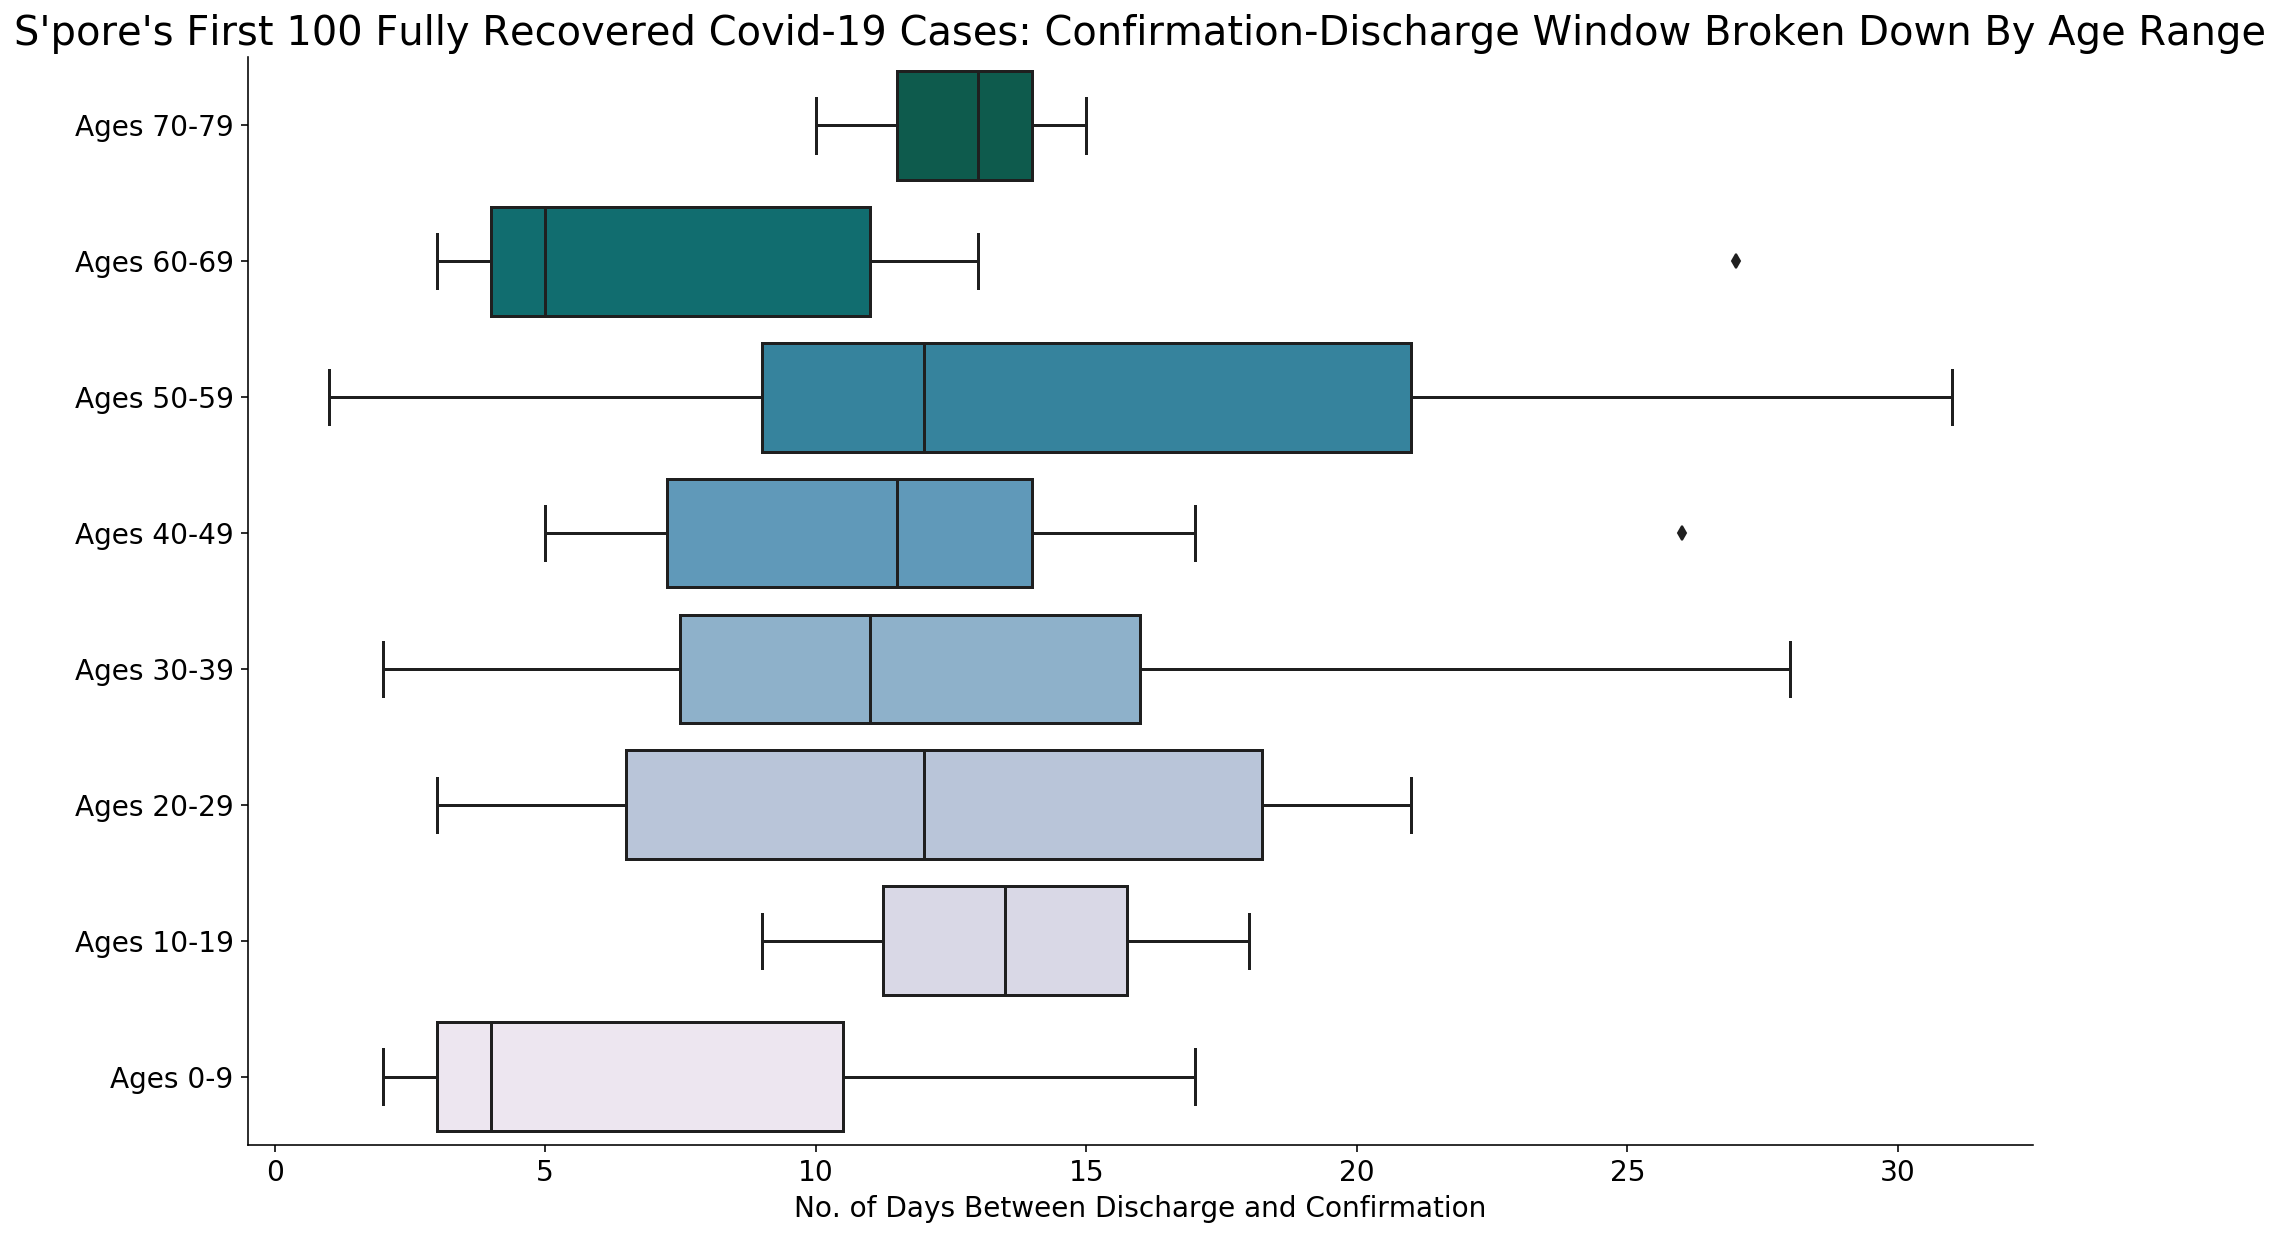

In [20]:
plt.figure(figsize=(16, 10))
sns.boxplot(
    x="Days Between Hospital Discharge And Covid-19 Confirmation",
    y="Age Range",
    data=age,
    palette="PuBuGn_r",
)
plt.title(
    "S'pore's First 100 Fully Recovered Covid-19 Cases: Confirmation-Discharge Window Broken Down By Age Range", fontsize=20
)
plt.xlabel("No. of Days Between Discharge and Confirmation", fontsize=14)
plt.ylabel("", fontsize=14)

plt.grid(False)
sns.despine()
plt.show()


### 3.4.2 AGE VS CONFIRMATION-DISCHARGE WINDOW: INTERACTIVE VERSION VIA FLOURISH STUDIO'S TEMPLATE

The interactive chart is available [here](https://public.flourish.studio/visualisation/1518465/). Hover over the points to see the detailed meta-data for each case.

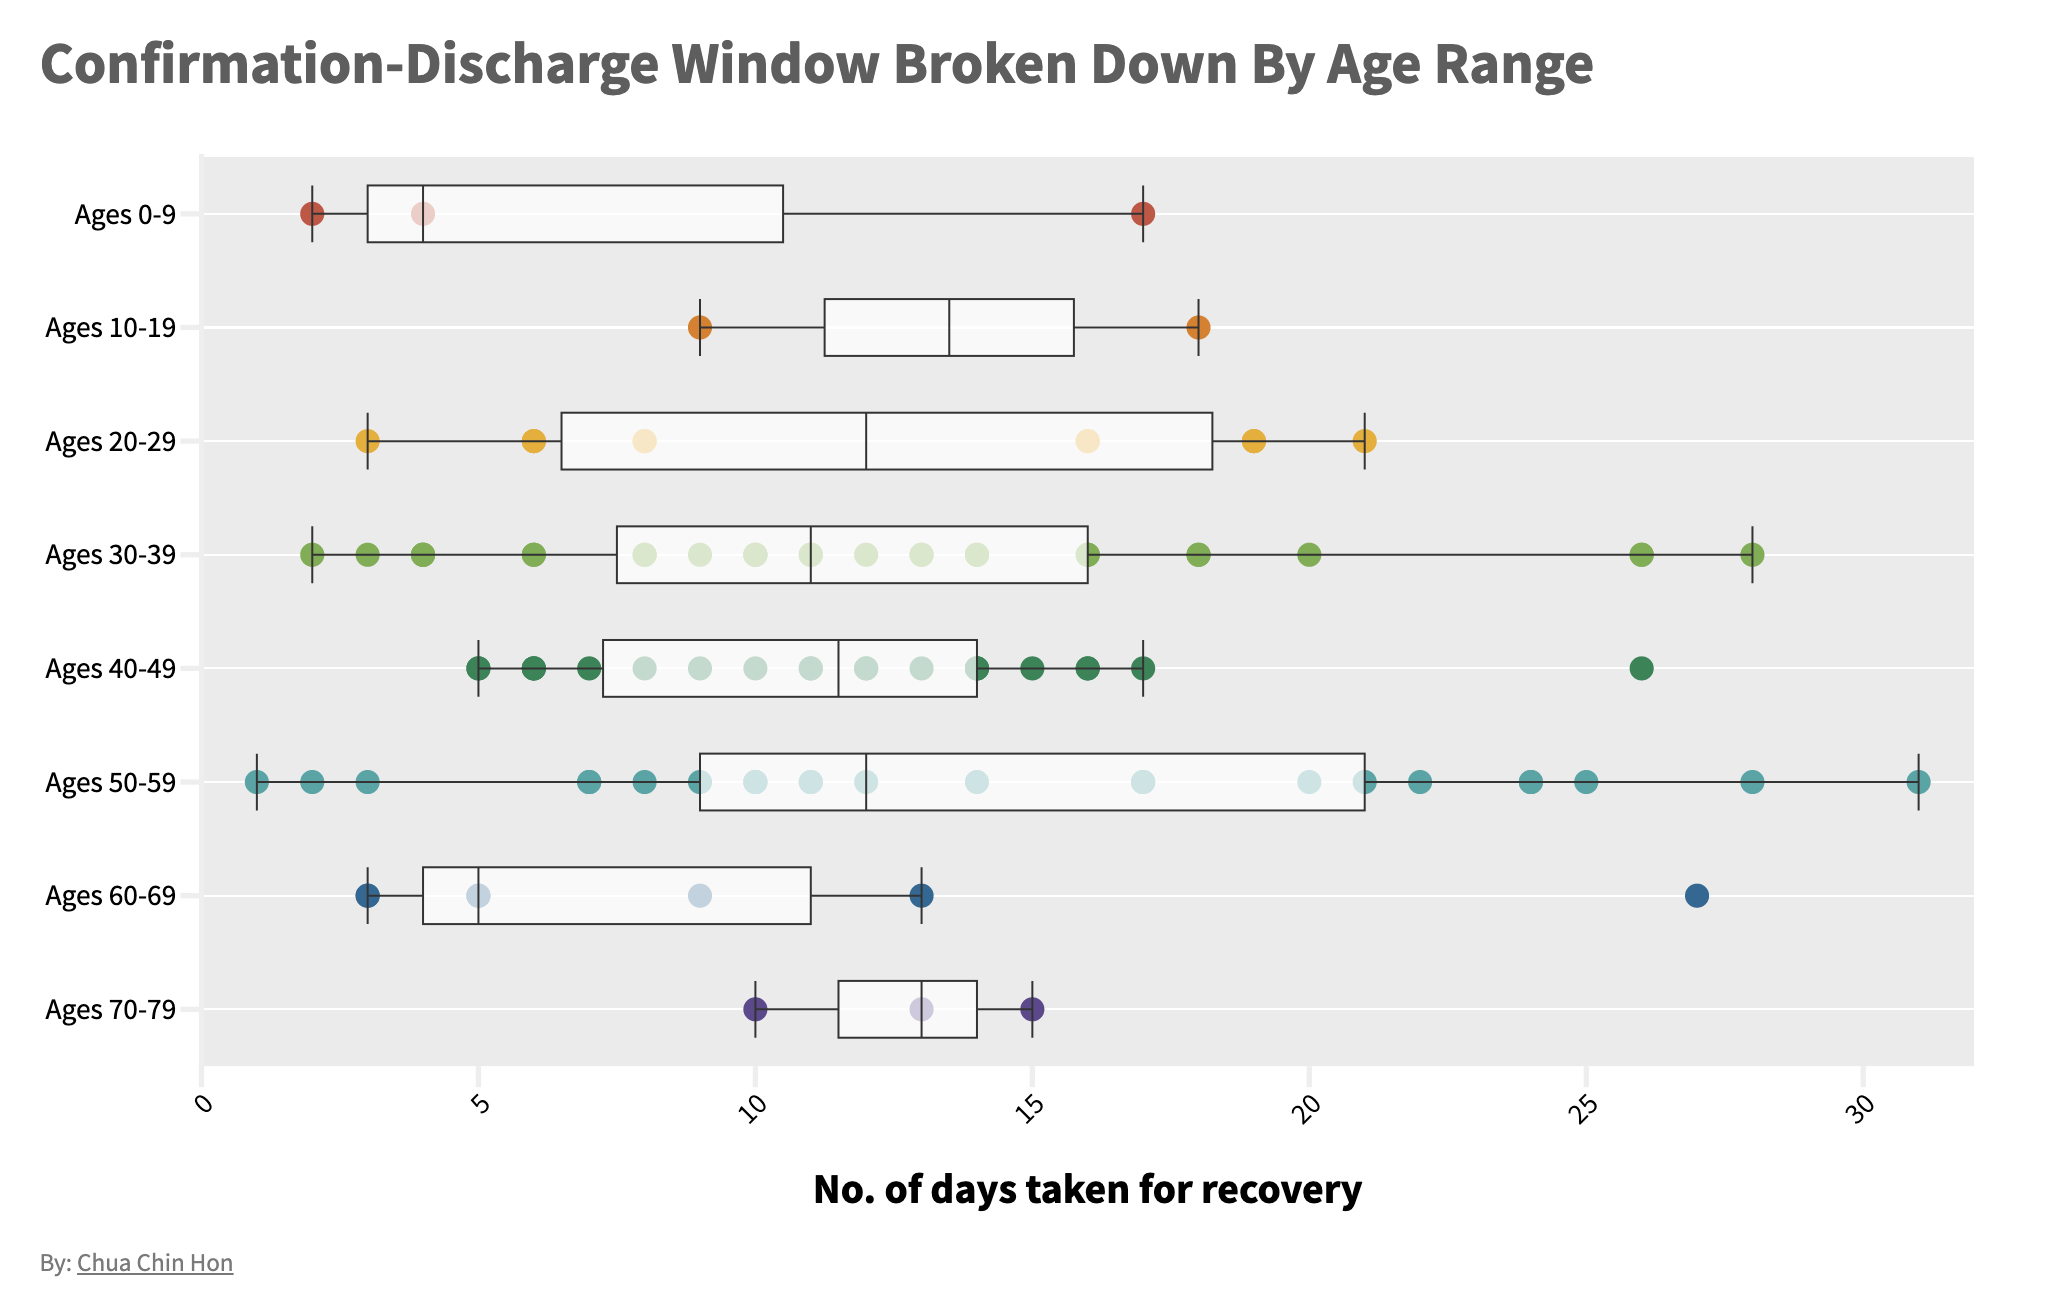

## ANALYSIS:


* With the exception of those in the youngest age group of under 9, who have a median confirmation-discharge window of 4 days, we don't see younger patients waging a full recovery significantly faster than the older ones. 

* The median number of days needed for full recovery in the age groups of 10-19, 20-29, and 40-49 are in fact longer than the overall median of 11 days for all 100 recovered patients. 

* This is surprising at first sight, but less so when you go back to the definition of a full recovery - which is that patients must show that they've stopped transmitting the virus, and not merely recovered from the symptoms. In other words, the median time needed to be virus-free might not deviate all that much across age groups, even if younger patients recover from the symptoms faster. This needs verification by the experts and a larger study, of course.

* The data for those in the 60-69 age group is highly unusual, with the median confirmation-discharge window at just 5 days and an outlier, Case 01, that took 27 days (2.5 times overall median) between confirmation of infection and discharge. I'll avoid over-interpreting this for the moment, given the small sample size in this initial exploration. 

# 4. AM I INFECTED OR NOT? DAYS BETWEEN ONSET OF SYMPTOMS AND CONFIRMATION

* This is tricky territory given the global disparity in access to medical facilities and Covid-19 test kits. 


* In Singapore, the health ministry releases a number of key dates for each Covid-19 case, including the dates of arrival in Singapore (for imported cases), and dates for self-initiated visits to a clinic or hospital (if applicable). The period of uncertainty between exposure to Covid-19 and official confirmation of infection can thus be defined in many ways, depending on how one combines the available dates.


* To avoid over-complicating matters, I'll use a straightforward definition of the pre-confirmation phase as the "symptoms-confirmation window", ie, the number of days between the reported onset of symptoms and official confirmation of Covid-19 infection.


* To be sure, there are some doubts about the veracity of the dates of onset of symptoms reported by the patients, particularly in times of stress and social stigma. But that's the most reliable "start date" that is consistently available in the Singapore context. 


* I opted not to use the dates involving hospital admissions and self-initiated visits to the clinics as the diagnosis on those occasions were not disclosed publicly.

# 4.1 OVERVIEW: 

* The median number of days between onset of symptoms and confirmation of Covid-19 infection is 6 days. But again, we see a huge gap between the maximum and minimum values in this phase, reflecting the complexities that some unusual cases present for doctors and health officials. 


* Eight cases reported having no symptoms prior to confirmation of infection.


* Case 151, which we briefly discussed earlier, nominally had a 33-day gap between onset of symptoms and confirmation of infection. But the reality is far more complicated, as we have seen from the health ministry's [press release](https://www.moh.gov.sg/news-highlights/details/three-more-cases-discharged-ten-new-cases-of-covid-19-infection-confirmed) on March 9. He began having symptoms on Feb 4, but it took a serological test on March 8 to confirm that he had an **earlier Covid-19** infection. The authorities did not say when exactly he was infected, or if the serological test could discern the date of a prior infection. Case 151 was discharged a day later on March 9.


* We'll have a look at the unusual cases, including those with no symptoms, but first an overall view via a frequency distribution bar chart and a Gantt chart.

In [21]:
print(
    "Average number of days between symptoms and confirmation: ",
    symptoms["Days Between Symptoms And Covid-19 Confirmation"].mean(),
)

print(
    "Median number of days between symptoms and confirmation: ",
    symptoms["Days Between Symptoms And Covid-19 Confirmation"].median(),
)

print(
    "Minimum number of between symptoms and confirmation: ",
    symptoms["Days Between Symptoms And Covid-19 Confirmation"].min(),
)

print(
    "Maximum number of days between symptoms and confirmation: ",
    symptoms["Days Between Symptoms And Covid-19 Confirmation"].max(),
)


Average number of days between symptoms and confirmation:  7.434782608695652
Median number of days between symptoms and confirmation:  6.0
Minimum number of between symptoms and confirmation:  1.0
Maximum number of days between symptoms and confirmation:  33.0


## 4.1.1 FREQUENCY DISTRIBUTION OF SYMPTOMS-CONFIRMATION WINDOW

## NOTE:

* Cases with an unusually long period between onset of symptoms and confirmation of infection are in the small minority - just 8 cases that took longer than the 14 days incubation period cited by most health agencies at the moment. But the highly infectious nature of Covid-19 still makes this small group one of significant concern, as it means they are out in the community for a longer period and with the potential to infect more people. 


* Among the 100 fully recovered patients, more than half of the 92 patients who had symptoms were confirmed as being Covid-19 positive within 7 days or less.

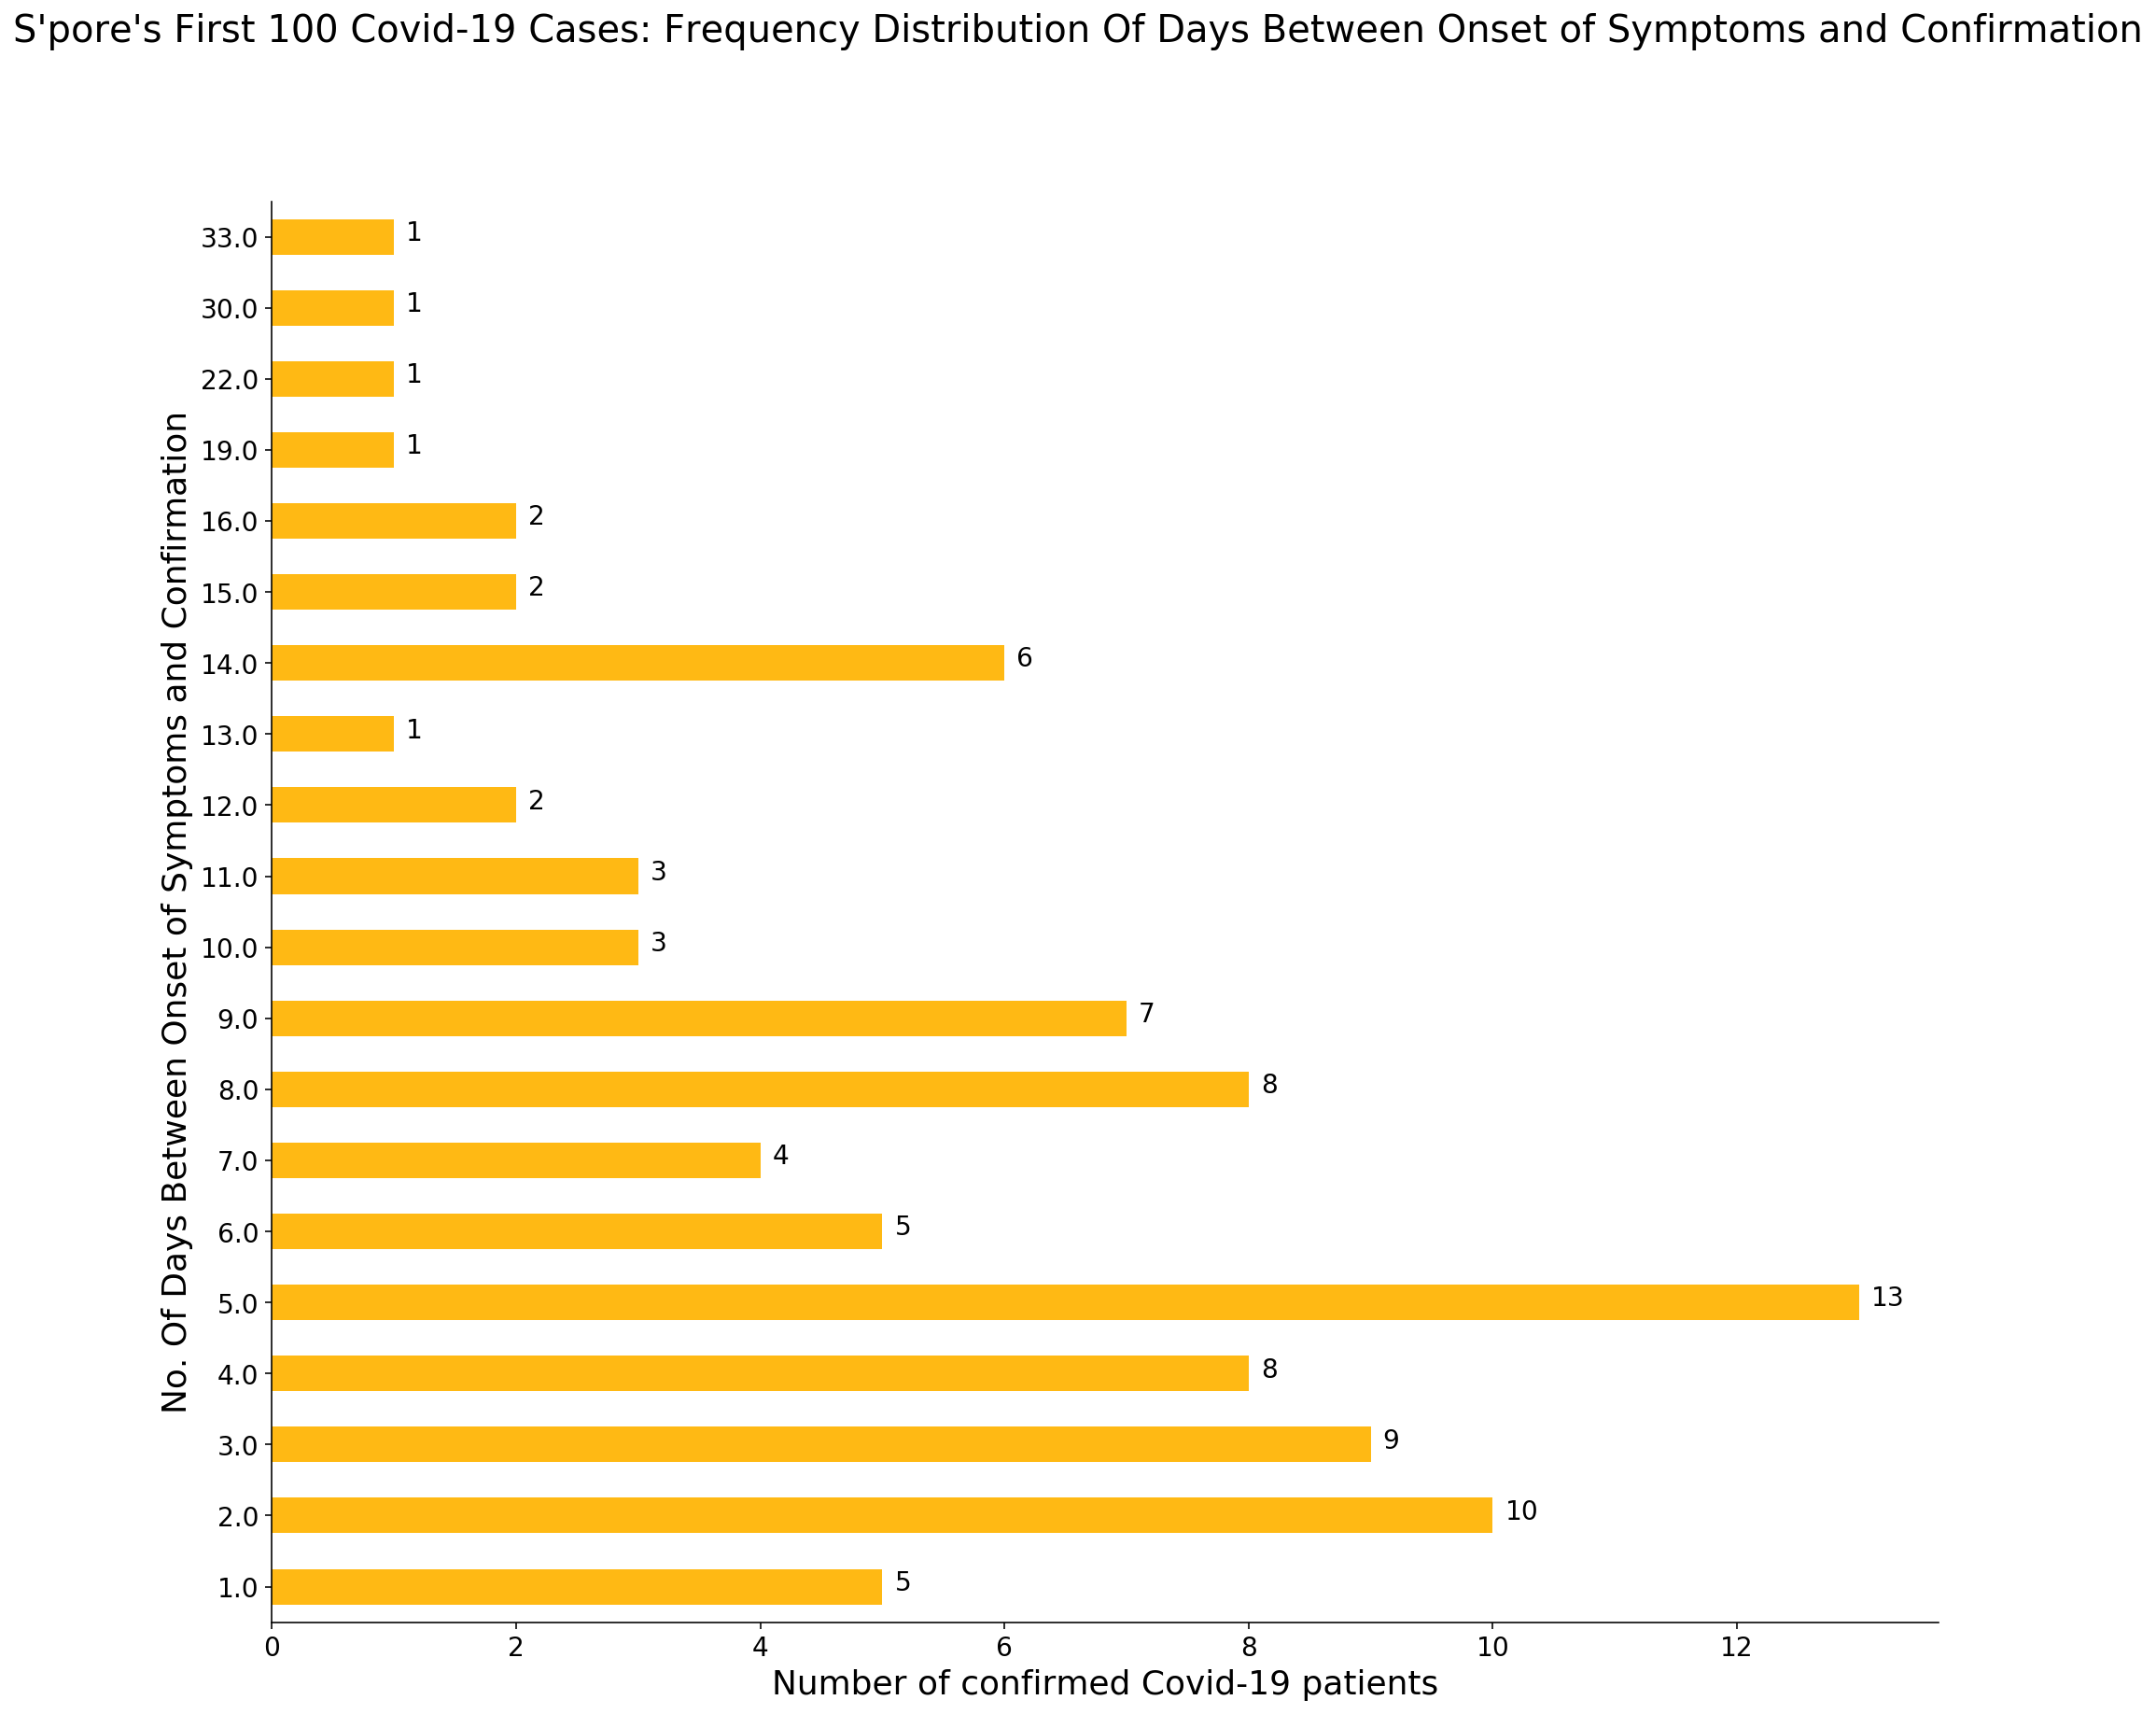

In [22]:
fig, ax = plt.subplots(figsize=(16, 14))

symptoms["Days Between Symptoms And Covid-19 Confirmation"].value_counts().sort_index(
    ascending=True
).plot(kind="barh", color="#ffb914")

totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.2, \
            str(round((i.get_width()))), fontsize=14, color='black')

fig.suptitle(
    "S'pore's First 100 Covid-19 Cases: Frequency Distribution Of Days Between Onset of Symptoms and Confirmation",
    fontsize=20,
)

plt.ylabel("No. Of Days Between Onset of Symptoms and Confirmation", fontsize=18)
plt.xlabel("Number of confirmed Covid-19 patients", fontsize=18)

ax.grid(False)
sns.despine()
plt.show()

## 4.1.2 GANTT CHART VISUALISATION OF SYMPTOMS-CONFIRMATION WINDOW

* Repeating the use of a Gantt chart, we can again tell which are the cases which took an unusually long time for the infection to be confirmed. Cases 151, 91, and 83 immediately stand out as highly challenging cases.

* You can download a copy of the interactive Plotly chart [here](https://www.dropbox.com/s/uj51tqn7qmc3rrs/symptoms_overview.html?dl=0).

In [23]:
symptoms_plotly = symptoms.rename(
    columns={
        "Confirmed Case ID": "Task",
        "Symptoms Date": "Start",
        "Confirmed Date": "Finish",
        "Days Between Symptoms And Covid-19 Confirmation": "Complete",
    }
)


In [24]:
fig_symptoms = ff.create_gantt(
    symptoms_plotly.dropna(),
    colors=['#ffa500', '#cc8400'],
    index_col="Complete",
    data="Complete",
    bar_width=0.4,
    height=1200,
    width=1000,
    title="S'pore's First 100 Fully Recovered Covid-19 Cases: Days Between Symptoms And Infection Confirmation"
)

fig_symptoms.show()

# 4.2 UNUSUAL CASES

## 4.2.1 COVID-19 PATIENTS WITH NO SYMPTOMS

* Among Singapore's first 100 fully recovered cases, eight patients (6 men and 2 women) had no obvious symptoms prior to confirmation of infection. They are: Cases 22, 23, 28, 65, 75, 76, 87, and 138.

* Four of the patients - Cases 22, 23, 76 and 87 - are Singaporeans evacuated from Wuhan on two separate flights, on Jan 30 and Feb 9. They reported no symptoms when they boarded the flight, but were quarantined upon arrival and then [tested for Covid-19 as an added precaution](https://www.moh.gov.sg/news-highlights/details/two-more-cases-discharged-three-new-cases-of-covid-19-infection-confirmed). They subsequently tested positive for Covid-19.

* The 4 locally transmitted cases with no details about the onset of symptoms are part of known Covid-19 clusters in Singapore. But the press releases by the health ministry have given no explanation as to why these patients had no symptoms prior to confirmation of infection. It could well be that information was established by medical workers in subsequent interviews with the patients, but was not released in subsequent updates). I don't know which is the case, for now.

* Patient 138 is another highly complex case - he tested positive on March 6, after he had served a 3-week quarantine and was allowed to leave home. The 26-year-old man, who was linked to two clusters involving local churches in Singapore, had to be recalled for further investigations after the positive test. He was given the all-clear on March 9 and discharged. More on this case in media reports [here](https://sg.news.yahoo.com/moh-clarifies-about-man-who-was-confirmed-covid-19-case-after-ending-quarantine-153635795.html) and [here](https://www.todayonline.com/singapore/gym-safra-punggol-closed-after-user-has-covid-19-gym-employees-stay-home-notice).

In [25]:
symptoms[symptoms["Symptoms Date"].isnull()]

Confirmed Case ID   Age   Age Range Gender  Category Nationality  \
21           Case 22  41.0  Ages 40-49      M  Imported   Singapore   
22           Case 23  17.0  Ages 10-19      M  Imported   Singapore   
27           Case 28   0.5    Ages 0-9      M     Local   Singapore   
61           Case 65  61.0  Ages 60-69      F     Local   Singapore   
71           Case 75  71.0  Ages 70-79      F     Local   Singapore   
72           Case 76   1.0    Ages 0-9      M  Imported   Singapore   
82           Case 87  32.0  Ages 30-39      M  Imported   Singapore   
97          Case 138  26.0  Ages 20-29      M     Local   Singapore   

   Symptoms Date Confirmed Date  \
21           NaT     2020-02-03   
22           NaT     2020-02-03   
27           NaT     2020-02-05   
61           NaT     2020-02-14   
71           NaT     2020-02-16   
72           NaT     2020-02-16   
82           NaT     2020-02-21   
97           NaT     2020-03-06   

    Days Between Symptoms And Covid-19 Confirmation  
21                                              NaN  
22                                              NaN  
27                                              NaN  
61                                              NaN  
71                                              NaN  
72                                              NaN  
82                                              NaN  
97                                              NaN

## 4.2.2 CASES WITH UNUSUALLY LONG GAP BETWEEN CONFIRMATION AND ONSET OF SYMPTOMS

* 8 patients took more than 14 days between onset of symptoms and confirmation of Covid-19. They are all cases of local transmission: Cases 30, 66, 68, 83, 84, 89, 91 and 151.

* Case 151 was discussed earlier. Case 91, who took 30 days between reported onset of symptoms and confirmation, first reported onset of symptoms on January 23 and sought treatment at a clinic on 3 separate occasions - on February 1, 6 and 10, according to the health ministry's press release dated [February 25](https://www.moh.gov.sg/news-highlights/details/five-more-cases-discharged-one-new-case-of-covid-19-infection-confirmed). 

* The ministry did not say what her diagnosis was on those occasions. She was referred to the National Centre for Infectious Diseases (NCID) on February 18 after she was identified as a contact of Case 66, the primary case of the Grace Assembly of God church cluster. She tested positive for Covid-19 only on the afternoon of February 22.

* The presence of these complex cases in part reflects the aggressive contact tracing regime in place in Singapore. In other countries where resources are under greater strain, or where the government has taken a more relaxed approach, they could have gone undetected. It is unclear how infectious these unusual cases are, but they stand out as one of the more complex challenges facing healthcare authorities who are trying to contain the outbreak.

In [26]:
symptoms[symptoms['Days Between Symptoms And Covid-19 Confirmation'] >= 15]

Confirmed Case ID   Age   Age Range Gender Category   Nationality  \
29           Case 30  27.0  Ages 20-29      M    Local     Singapore   
62           Case 66  28.0  Ages 20-29      M    Local     Singapore   
64           Case 68  79.0  Ages 70-79      F    Local     Singapore   
78           Case 83  54.0  Ages 50-59      M    Local     Singapore   
79           Case 84  35.0  Ages 30-39      F    Local     Singapore   
84           Case 89  41.0  Ages 40-49      M    Local  Singapore PR   
85           Case 91  58.0  Ages 50-59      F    Local     Singapore   
99          Case 151  51.0  Ages 50-59      M    Local     Singapore   

   Symptoms Date Confirmed Date  \
29    2020-01-21     2020-02-06   
62    2020-01-29     2020-02-14   
64    2020-01-30     2020-02-14   
78    2020-01-28     2020-02-19   
79    2020-02-04     2020-02-19   
84    2020-02-03     2020-02-22   
85    2020-01-23     2020-02-22   
99    2020-02-04     2020-03-08   

    Days Between Symptoms And Covid-19 Confirmation  
29                                             16.0  
62                                             16.0  
64                                             15.0  
78                                             22.0  
79                                             15.0  
84                                             19.0  
85                                             30.0  
99                                             33.0

## NOTE: 

* I won't further break down the data for the symptoms-confirmation window further, as it is not clear to me that gender and age would be more important in this context than, say, a person's recent social activities. There's probably a more scientific way to study this tricky pre-infection-confirmation phase, and that's better left to the experts.

# 5. END NOTES:

* What about predictions? Well, I'm staying well clear of this. There's not enough data in the Singapore context, where there are just 212 cases at the time of writing on March 16 2020. And for once, I hope we won't have enough data, and the number of cases are kept as low as possible.

* I'll leave projections of exponential growth and charts on "flattening the curve" to more experienced analysts. I'm personally unsure about many of these charts given the knowledge gaps about Covid-19. So again, I'll prefer to leave that to the experts.

* Let me know if you spot errors or do something interesting with this small dataset from Singapore. Ping me at:

 - Twitter: @chinhon
 
 - LinkedIn: www.linkedin.com/in/chuachinhon

#     -- END --